## 환경 설정

In [1]:
! pip install transformers
! pip install sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 3.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [2]:
! pip install mplcursors

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 1.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 48.8 MB/s eta 0:00:00
  Created wheel for mplcursors: filename=mplcursors-0.5.3-py3-none-any.whl size=20727 sha256=10bfee36b26ebc0a894bf7713e1e0afd5991324ca290b8c22a0af285db1f57d0
  Stored in directory: /root/.cache/pip/wheels/83/43/92/44f9515471f56877c774a515a2902d3e5484ea1bc7fd412d03
Successfully built mplcursors
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1


In [3]:
import glob
import os
import re

## 함수

In [4]:
def tokenize_tree(tree):
    # 특수 문자를 이스케이프하여 정규 표현식 적용 + 괄호는 넣기
    special_characters = r"[\*\+\./:;<=\?\[\]\^_`{|}~\(\)]"
    tokenized_tree = re.findall(r"\b\w+\b|" + special_characters + r"|\u2192", str(tree))
    return tokenized_tree

In [5]:
def embed_processes_with_sbert(tokenized_processes):

    # 임베딩을 저장할 리스트 초기화
    sbert_embeddings = []

    # tokenized_processes에 대한 반복문
    for tree_tokens in tokenized_processes:
        # 프로세스 트리를 텍스트로 펼치고 토큰화
        process_tree_text = " ".join(tree_tokens)

        # SBERT 모델을 사용하여 문장 임베딩 얻기
        sbert_embedding = sbert_model.encode([process_tree_text])

        # 평균 풀링
        average_pooled_embedding = np.mean(sbert_embedding, axis=0)
        sbert_embeddings.append(average_pooled_embedding)

    # 모든 프로세스 트리에 대한 임베딩이 sbert_embeddings에 저장됨
    return sbert_embeddings

In [6]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def cosine_avg(embeddings_groups, output_file):
    num_groups = len(embeddings_groups)
    similarity_matrix = np.zeros((num_groups, num_groups))

    for i in range(num_groups):
        for j in range(i, num_groups):
            embeddings1 = embeddings_groups[i]
            embeddings2 = embeddings_groups[j]

            # Check if either group is empty
            if len(embeddings1) == 0 or len(embeddings2) == 0:
                similarity_matrix[i, j] = 0
            else:
                similarity_matrix[i, j] = np.mean(cosine_similarity(embeddings1, embeddings2))

    # Fill in the lower triangle of the matrix with 0s
    similarity_matrix = np.triu(similarity_matrix)

    # Print the similarity matrix
    print("Similarity Matrix:")
    print(similarity_matrix)

    # Save the similarity matrix to a CSV file
    np.savetxt(output_file, similarity_matrix, delimiter=",")

In [7]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

def plot_distance(idx_pairs, reduced_embeddings_tsne, embedding_matrix, labels, clusters):
    num_pairs = len(idx_pairs)
    num_rows = (num_pairs + 1) // 2  # Calculate number of rows needed based on number of pairs

    # Create the subplot layout, handle case with only one pair differently
    if num_pairs == 1:
        fig, axs = plt.subplots(1, 1, figsize=(14, 7))
        axs = np.array([axs])  # Ensure axs is an array for consistent indexing
    else:
        fig, axs = plt.subplots(num_rows, 2, figsize=(14, 7 * num_rows))

    for i, idx in enumerate(idx_pairs):
        # Calculate cosine similarity and convert to distance
        vec1 = embedding_matrix[idx[0]].reshape(1, -1)
        vec2 = embedding_matrix[idx[1]].reshape(1, -1)
        cos_sim = cosine_similarity(vec1, vec2)[0, 0]
        distance = 1 - cos_sim

        # Determine the subplot position
        row = i // 2
        col = i % 2

        # Plot on the appropriate subplot
        if num_pairs == 1:
            ax = axs[0]
        elif num_rows == 1:
            ax = axs[col]
        else:
            ax = axs[row, col]

        scatter = ax.scatter(reduced_embeddings_tsne[:, 0], reduced_embeddings_tsne[:, 1], c=clusters, cmap='viridis', alpha=0.5)
        ax.scatter(reduced_embeddings_tsne[idx[0], 0], reduced_embeddings_tsne[idx[0], 1], color='red', label=labels[idx[0]])
        ax.scatter(reduced_embeddings_tsne[idx[1], 0], reduced_embeddings_tsne[idx[1], 1], color='blue', label=labels[idx[1]])
        ax.plot([reduced_embeddings_tsne[idx[0], 0], reduced_embeddings_tsne[idx[1], 0]],
                [reduced_embeddings_tsne[idx[0], 1], reduced_embeddings_tsne[idx[1], 1]], 'k--', label=f'Distance: {distance:.2f}')

        ax.legend()

        # Print distance and labels
        print(f"Cosine similarity between index {idx[0]} and index {idx[1]}: {cos_sim:.2f}")
        print(f"Distance between index {idx[0]} and index {idx[1]}: {distance:.2f}")
        print(f"Label for index {idx[0]}: {labels[idx[0]]}")
        print(f"Label for index {idx[1]}: {labels[idx[1]]}")

    # Hide any remaining empty subplots if num_pairs is not even
    if num_pairs < num_rows * 2 and num_pairs > 1:
        for j in range(num_pairs, num_rows * 2):
            row = j // 2
            col = j % 2
            axs[row, col].axis('off')

    plt.tight_layout()
    plt.show()

In [8]:
from sentence_transformers import SentenceTransformer

# 모델을 저장한 경로
model_path = "/content/drive/MyDrive/PMLAB/sbert_fine_tuned_BPIC"

# 저장된 모델 불러오기
sbert_model = SentenceTransformer(model_path)

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


## Embedding (noise 20)

In [ ]:
import glob
import os
import re

cases = []

for i in range(20):
    folder_paths = [
        # f'/content/drive/MyDrive/PMLAB/noise_20_80/noise20/BPIC15_1_rev/case{i}',
        # f'/content/drive/MyDrive/PMLAB/noise_20_80/noise20/BPIC15_2_rev/case{i}',
        # f'/content/drive/MyDrive/PMLAB/noise_20_80/noise20/BPIC15_3_rev/case{i}',
        # f'/content/drive/MyDrive/PMLAB/noise_20_80/noise20/BPIC15_4_rev/case{i}',
        f'/content/drive/MyDrive/PMLAB/noise_20_80/noise20/BPIC15_5_rev/case{i}'
    ]

    case_data = []

    for folder_path in folder_paths:
        file_path_list = glob.glob(os.path.join(folder_path, "*.txt"))
        for file_path in file_path_list:
            with open(file_path, 'r') as file:
                for line in file:
                    pattern = r'"(.*?)"'
                    matches = re.findall(pattern, line)
                    if matches:  # matches 리스트가 비어 있지 않은 경우에만 처리
                        match = matches[0].replace("->", "\u2192")
                        case_data.append(match.replace('"', ""))

    cases.append(case_data)

In [ ]:
# Tokenize each group
tokenized_group = []
for cas in cases:
    tokenized_group.append([tokenize_tree(tree) for tree in cas])

In [ ]:
embeddings_groups_sbert = []
for i in range(len(tokenized_group)):
    f'sbert_embeddings_{i} = []'
    f'embeddings_groups_sbert.append(sbert_embeddings_{i})'

for idx, group in enumerate(tokenized_group):
    sbert_embeddings = embed_processes_with_sbert(group)
    exec(f"embeddings_groups_sbert.append(sbert_embeddings)")

In [ ]:
cosine_avg(embeddings_groups_sbert, "result_noise20_BPIC_1.csv")

Similarity Matrix:
[[1.         0.         0.7773273  0.75659108 0.76607037 0.80436665
  0.78969043 0.71149832 0.76786166 0.73755503 0.         0.63393778
  0.61246121 0.76064742 0.73889095 0.82784563 0.79493821 0.
  0.7203986  0.71708393]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         1.00000012 0.97769773 0.98217994 0.94525421
  0.87749088 0.87146157 0.87886196 0.86707985 0.         0.81808048
  0.78906286 0.89599252 0.89117801 0.876881   0.93455243 0.
  0.90846652 0.9289279 ]
 [0.         0.         0.         1.         0.99311256 0.95355797
  0.86759633 0.86693382 0.88659763 0.87816864 0.         0.83863741
  0.78916168 0.90143907 0.91524631 0.88366711 0.93043733 0.
  0.9194994  0.92340147]
 [0.         0.         0.         0.         0.99999988 0.95230383
  0.87160808 0.867172   0.88989532 0.88027501

In [ ]:
cosine_avg(embeddings_groups_sbert, "result_noise20_BPIC_2.csv")

Similarity Matrix:
[[1.         0.         0.96584141 0.80959922 0.76910245 0.76893103
  0.73228228 0.         0.81360161 0.86602378 0.         0.80741525
  0.         0.60174859 0.75582588 0.71849376 0.8118856  0.81594884
  0.75795913 0.66588551]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.99999988 0.79119802 0.76071    0.75827861
  0.72180414 0.         0.80572087 0.86951864 0.         0.81135917
  0.         0.61289036 0.78379148 0.71690392 0.80184472 0.81717885
  0.77284008 0.70845592]
 [0.         0.         0.         1.         0.88348985 0.88593686
  0.95597959 0.         0.96952373 0.81060785 0.         0.86125028
  0.         0.80546463 0.80394715 0.88637012 0.87718928 0.91110206
  0.92238021 0.87956715]
 [0.         0.         0.         0.         1.00000012 0.94566095
  0.89821064 0.      

In [ ]:
cosine_avg(embeddings_groups_sbert, "result_noise20_BPIC_3.csv")

Similarity Matrix:
[[0.99999988 0.         0.7814635  0.74929833 0.70381361 0.70822459
  0.69465572 0.65972376 0.69918799 0.78476363 0.         0.
  0.64916515 0.76496184 0.77425253 0.77506059 0.71728873 0.
  0.75958031 0.75050211]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.99999988 0.97231042 0.93439674 0.84750336
  0.88106662 0.8628813  0.9024629  0.93116236 0.         0.
  0.87933075 0.93449771 0.94986504 0.94560838 0.88301218 0.
  0.90730906 0.84973717]
 [0.         0.         0.         1.00000012 0.91387981 0.83661002
  0.88075709 0.8595295  0.89892864 0.90720004 0.         0.
  0.88797277 0.9251588  0.95867866 0.96704328 0.8856163  0.
  0.93123865 0.86920309]
 [0.         0.         0.         0.         1.00000024 0.91593421
  0.86696231 0.89093637 0.93581569 0.91245425 0.         0.
  0.91110

In [ ]:
cosine_avg(embeddings_groups_sbert, "result_noise20_BPIC_4.csv")

Similarity Matrix:
[[1.         0.         0.9325459  0.93609428 0.85477525 0.79598272
  0.91458404 0.91772372 0.89055598 0.90796936 0.         0.88770807
  0.8706398  0.83562374 0.81072772 0.8017056  0.82687211 0.
  0.76601177 0.88483381]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         1.00000012 0.92632258 0.80738693 0.69424748
  0.93881792 0.92844111 0.9298299  0.9455058  0.         0.9441272
  0.91867638 0.86201227 0.87110209 0.87321711 0.88507378 0.
  0.82655615 0.94268656]
 [0.         0.         0.         1.         0.89255041 0.80277669
  0.912359   0.92219448 0.90447068 0.92159832 0.         0.92618197
  0.90234101 0.85073972 0.86163938 0.84806478 0.8886447  0.
  0.82693148 0.9025746 ]
 [0.         0.         0.         0.         1.00000012 0.8789438
  0.75651842 0.7939353  0.76019704 0.77982676 0

In [ ]:
cosine_avg(embeddings_groups_sbert, "result_noise20_BPIC_5.csv")

Similarity Matrix:
[[1.         0.         0.85465753 0.7986694  0.         0.82324708
  0.81186509 0.82649148 0.80876887 0.82700062 0.         0.79648548
  0.83103085 0.76125515 0.73326331 0.80678469 0.79846644 0.
  0.75310701 0.75194395]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         1.         0.91596359 0.         0.81931281
  0.84541786 0.83218688 0.83538163 0.86451834 0.         0.85098439
  0.84645641 0.84735948 0.77397388 0.83379865 0.77967107 0.
  0.79583752 0.81089765]
 [0.         0.         0.         1.00000012 0.         0.86155498
  0.91000277 0.86928856 0.88494241 0.9305867  0.         0.92218041
  0.88565099 0.92054868 0.84382528 0.86314297 0.81466866 0.
  0.8691054  0.81575078]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.     

## Embedding (noise 80)

In [ ]:
import glob
import os
import re

cases = []

for i in range(20):
    folder_paths = [
        # f'/content/drive/MyDrive/PMLAB/noise_20_80/noise80/BPIC15_1_rev/case{i}',
        # f'/content/drive/MyDrive/PMLAB/noise_20_80/noise80/BPIC15_2_rev/case{i}',
        # f'/content/drive/MyDrive/PMLAB/noise_20_80/noise80/BPIC15_3_rev/case{i}',
        # f'/content/drive/MyDrive/PMLAB/noise_20_80/noise80/BPIC15_4_rev/case{i}',
        f'/content/drive/MyDrive/PMLAB/noise_20_80/noise80/BPIC15_5_rev/case{i}'
    ]

    case_data = []

    for folder_path in folder_paths:
        file_path_list = glob.glob(os.path.join(folder_path, "*.txt"))
        for file_path in file_path_list:
            with open(file_path, 'r') as file:
                for line in file:
                    pattern = r'"(.*?)"'
                    matches = re.findall(pattern, line)
                    if matches:  # matches 리스트가 비어 있지 않은 경우에만 처리
                        match = matches[0].replace("->", "\u2192")
                        case_data.append(match.replace('"', ""))

    cases.append(case_data)

In [ ]:
# Tokenize each group
tokenized_group = []
for cas in cases:
    tokenized_group.append([tokenize_tree(tree) for tree in cas])

In [ ]:
embeddings_groups_sbert = []
for i in range(len(tokenized_group)):
    f'sbert_embeddings_{i} = []'
    f'embeddings_groups_sbert.append(sbert_embeddings_{i})'

for idx, group in enumerate(tokenized_group):
    sbert_embeddings = embed_processes_with_sbert(group)
    exec(f"embeddings_groups_sbert.append(sbert_embeddings)")

In [ ]:
cosine_avg(embeddings_groups_sbert, "result_noise80_BPIC_1.csv")

Similarity Matrix:
[[1.         0.         0.85040337 0.73123616 0.73401803 0.68874729
  0.73454654 0.71386504 0.76338744 0.81329989 0.         0.70742249
  0.68343604 0.76117373 0.80753481 0.82489455 0.72131395 0.
  0.76674557 0.75740349]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.99999988 0.92536724 0.92974287 0.823129
  0.89220947 0.86707211 0.91220504 0.85846788 0.         0.80142057
  0.76822108 0.8994751  0.88902402 0.86644608 0.84411097 0.
  0.92394793 0.89525068]
 [0.         0.         0.         1.         0.99530578 0.84701711
  0.90284836 0.90872389 0.89549613 0.84327275 0.         0.83566999
  0.7914415  0.88023168 0.85550809 0.796076   0.86148918 0.
  0.92359418 0.8990714 ]
 [0.         0.         0.         0.         1.00000024 0.85064113
  0.90894628 0.91002995 0.90206718 0.85197687 0

In [ ]:
cosine_avg(embeddings_groups_sbert, "result_noise80_BPIC_2.csv")

Similarity Matrix:
[[1.00000012 0.         0.94697189 0.86625755 0.80303133 0.85548389
  0.80209053 0.         0.84053397 0.84777427 0.         0.69842577
  0.         0.64806116 0.61682498 0.93173146 0.70279562 0.90984631
  0.65345943 0.58063036]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         1.00000024 0.84346938 0.81876725 0.84772766
  0.76347107 0.         0.80361402 0.85929626 0.         0.69366676
  0.         0.67415833 0.6504184  0.88083136 0.68082035 0.84655607
  0.6652782  0.55205017]
 [0.         0.         0.         1.00000012 0.95913333 0.84251583
  0.88412869 0.         0.87825251 0.84624779 0.         0.78716826
  0.         0.76629239 0.72975457 0.90079433 0.7910561  0.84480691
  0.79291523 0.69784796]
 [0.         0.         0.         0.         1.00000024 0.85358506
  0.8640576  0.      

In [ ]:
cosine_avg(embeddings_groups_sbert, "result_noise80_BPIC_3.csv")

Similarity Matrix:
[[1.00000024 0.         0.73353702 0.7741192  0.82255483 0.7737444
  0.69251096 0.78082037 0.79506195 0.80061209 0.         0.
  0.7536751  0.76925039 0.74185097 0.70600498 0.83197141 0.
  0.7777558  0.74784273]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         1.00000012 0.89422476 0.87730843 0.82385254
  0.84152442 0.82745099 0.82776904 0.85431051 0.         0.
  0.80409992 0.82307535 0.91778958 0.81301761 0.79558647 0.
  0.80409229 0.84349144]
 [0.         0.         0.         0.99999988 0.88916487 0.83848256
  0.83961594 0.82528192 0.83651948 0.83370566 0.         0.
  0.78101021 0.8205173  0.85418141 0.83763862 0.86114585 0.
  0.77598912 0.80069298]
 [0.         0.         0.         0.         1.00000012 0.96407521
  0.84582365 0.88851905 0.86834103 0.91553307 0.         0.
  0.819837

In [ ]:
cosine_avg(embeddings_groups_sbert, "result_noise80_BPIC_4.csv")

Similarity Matrix:
[[1.00000012 0.         0.88975811 0.89936996 0.85705113 0.87000906
  0.81647229 0.78871214 0.75152588 0.80728298 0.         0.83198142
  0.83584118 0.78273296 0.75795257 0.77559161 0.77616227 0.
  0.79491836 0.70500392]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         1.         0.93403906 0.87235928 0.80825597
  0.82287067 0.78816789 0.82005274 0.90331954 0.         0.84750193
  0.83022535 0.80164909 0.79298282 0.82864195 0.83772182 0.
  0.83587378 0.8007521 ]
 [0.         0.         0.         1.         0.93012077 0.8441
  0.87783086 0.85300034 0.85448164 0.87615597 0.         0.87730908
  0.87066382 0.84799838 0.83223367 0.84775591 0.87703407 0.
  0.8619628  0.79747653]
 [0.         0.         0.         0.         0.99999988 0.90024275
  0.76755148 0.72622508 0.71518952 0.82084572 0. 

In [ ]:
cosine_avg(embeddings_groups_sbert, "result_noise80_BPIC_5.csv")

Similarity Matrix:
[[1.         0.         0.80209291 0.81864917 0.81585348 0.78800315
  0.75457597 0.75597441 0.78451288 0.83920366 0.         0.77536988
  0.80892873 0.68693817 0.72641909 0.66052508 0.851776   0.
  0.67779589 0.74530888]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         1.         0.92326248 0.88094014 0.85246933
  0.90512753 0.93307024 0.88080317 0.86060333 0.         0.92149276
  0.90772128 0.87760937 0.76705378 0.81354141 0.88487631 0.
  0.89415056 0.79244298]
 [0.         0.         0.         0.99999994 0.9857319  0.89065385
  0.9250316  0.93193305 0.85750341 0.90149415 0.         0.9315598
  0.92173821 0.86274916 0.79966772 0.74928689 0.86883855 0.
  0.84764564 0.73295701]
 [0.         0.         0.         0.         1.         0.87438285
  0.90420878 0.90318775 0.8431645  0.91048789 

## Embedding (noise 20, interval 5)

In [ ]:
import glob
import os
import re

cases = []

folder_path = '/content/drive/MyDrive/PMLAB/noise_20_80/noise20_num_interval5'

file_path_list = sorted(glob.glob(os.path.join(folder_path, "*.txt")))

for file_path in file_path_list:
    case_data = []  # 각 파일마다 case_data 초기화
    with open(file_path, 'r') as file:
        for line in file:
            pattern = r'"(.*?)"'
            matches = re.findall(pattern, line)
            if matches:  # matches 리스트가 비어 있지 않은 경우에만 처리
                match = [matches[0].replace("->", "\u2192").replace('"', "")]
                case_data.append(match)
        cases.append(case_data)

In [ ]:
# Tokenize each group
tokenized_groups = []
for case in cases:
    tokenized_group = []
    for group in case:
        tokenized_group.append([tokenize_tree(tree) for tree in group])
    tokenized_groups.append(tokenized_group)

In [ ]:
def similarity_by_group(tokenized_groups, idx):
    embeddings_groups_sbert = []
    for i in range(len(tokenized_groups[idx])):
        f'sbert_embeddings_{i} = []'
        f'embeddings_groups_sbert.append(sbert_embeddings_{i})'

    for idx, group in enumerate(tokenized_groups[idx]):
        sbert_embeddings = embed_processes_with_sbert(group)
        exec(f"embeddings_groups_sbert.append(sbert_embeddings)")

    return embeddings_groups_sbert

In [ ]:
result_1 = similarity_by_group(tokenized_groups, 0)
cosine_avg(result_1, f"{folder_path}/result_noise20_interval5_BPIC_1.csv")

Similarity Matrix:
[[1.00000012 0.88848752 0.85710567 0.86851954 0.87403369]
 [0.         1.         0.8827219  0.89765877 0.92103755]
 [0.         0.         1.         0.88174987 0.80922294]
 [0.         0.         0.         0.99999988 0.87182939]
 [0.         0.         0.         0.         1.        ]]


In [ ]:
result_2 = similarity_by_group(tokenized_groups, 1)
cosine_avg(result_2, f"{folder_path}/result_noise20_interval5_BPIC_2.csv")

Similarity Matrix:
[[1.00000012 0.92796969 0.93234569 0.76436156 0.8387239 ]
 [0.         1.00000024 0.96178818 0.74351889 0.818416  ]
 [0.         0.         1.         0.75054157 0.86829782]
 [0.         0.         0.         1.         0.75960249]
 [0.         0.         0.         0.         1.        ]]


In [ ]:
result_3 = similarity_by_group(tokenized_groups, 2)
cosine_avg(result_3, f"{folder_path}/result_noise20_interval5_BPIC_3.csv")

Similarity Matrix:
[[1.00000024 0.92725098 0.89316678 0.8792069  0.87308311]
 [0.         1.00000024 0.88791108 0.84338725 0.82718706]
 [0.         0.         1.00000012 0.89429015 0.89120877]
 [0.         0.         0.         1.00000024 0.96539003]
 [0.         0.         0.         0.         1.00000012]]


In [ ]:
result_4 = similarity_by_group(tokenized_groups, 3)
cosine_avg(result_4, f"{folder_path}/result_noise20_interval5_BPIC_4.csv")

Similarity Matrix:
[[1.00000024 0.9179222  0.88268131 0.93586445 0.88705802]
 [0.         1.00000012 0.92444652 0.90189832 0.87077016]
 [0.         0.         1.00000012 0.84734994 0.79905707]
 [0.         0.         0.         1.00000024 0.8939122 ]
 [0.         0.         0.         0.         0.99999994]]


In [ ]:
result_5 = similarity_by_group(tokenized_groups, 4)
cosine_avg(result_5, f"{folder_path}/result_noise20_interval5_BPIC_5.csv")

Similarity Matrix:
[[1.00000012 0.84429085 0.83538163 0.87047458 0.78351378]
 [0.         1.00000012 0.959867   0.84658897 0.88371837]
 [0.         0.         1.         0.86210287 0.86520797]
 [0.         0.         0.         1.         0.88134277]
 [0.         0.         0.         0.         1.00000012]]


## Embedding (noise 80, interval 5)

In [ ]:
import glob
import os
import re

cases = []

folder_path = '/content/drive/MyDrive/PMLAB/noise_20_80/noise80_num_interval5'

file_path_list = sorted(glob.glob(os.path.join(folder_path, "*.txt")))

for file_path in file_path_list:
    case_data = []  # 각 파일마다 case_data 초기화
    with open(file_path, 'r') as file:
        for line in file:
            pattern = r'"(.*?)"'
            matches = re.findall(pattern, line)
            if matches:  # matches 리스트가 비어 있지 않은 경우에만 처리
                match = [matches[0].replace("->", "\u2192").replace('"', "")]
                case_data.append(match)
        cases.append(case_data)

In [ ]:
# Tokenize each group
tokenized_groups = []
for case in cases:
    tokenized_group = []
    for group in case:
        tokenized_group.append([tokenize_tree(tree) for tree in group])
    tokenized_groups.append(tokenized_group)

In [ ]:
def similarity_by_group(tokenized_groups, idx):
    embeddings_groups_sbert = []
    for i in range(len(tokenized_groups[idx])):
        f'sbert_embeddings_{i} = []'
        f'embeddings_groups_sbert.append(sbert_embeddings_{i})'

    for idx, group in enumerate(tokenized_groups[idx]):
        sbert_embeddings = embed_processes_with_sbert(group)
        exec(f"embeddings_groups_sbert.append(sbert_embeddings)")

    return embeddings_groups_sbert

In [ ]:
result_1 = similarity_by_group(tokenized_groups, 0)
cosine_avg(result_1, f"{folder_path}/result_noise80_interval5_BPIC_1.csv")

Similarity Matrix:
[[1.00000012 0.75209373 0.88535863 0.75193048 0.85646498]
 [0.         1.00000012 0.8761996  0.85783738 0.72999239]
 [0.         0.         1.         0.84878385 0.79569769]
 [0.         0.         0.         1.00000012 0.73975384]
 [0.         0.         0.         0.         1.        ]]


In [ ]:
result_2 = similarity_by_group(tokenized_groups, 1)
cosine_avg(result_2, f"{folder_path}/result_noise80_interval5_BPIC_2.csv")

Similarity Matrix:
[[1.00000012 0.80096912 0.83871698 0.6933189  0.83347738]
 [0.         1.         0.91549814 0.78856897 0.78128219]
 [0.         0.         1.         0.7590512  0.80078506]
 [0.         0.         0.         1.         0.72127318]
 [0.         0.         0.         0.         1.        ]]


In [ ]:
result_3 = similarity_by_group(tokenized_groups, 2)
cosine_avg(result_3, f"{folder_path}/result_noise80_interval5_BPIC_3.csv")

Similarity Matrix:
[[0.99999976 0.86080015 0.82582456 0.88753444 0.90504158]
 [0.         1.         0.89774001 0.83769906 0.8441633 ]
 [0.         0.         1.         0.87708604 0.85390007]
 [0.         0.         0.         1.         0.89371949]
 [0.         0.         0.         0.         1.        ]]


In [ ]:
result_4 = similarity_by_group(tokenized_groups, 3)
cosine_avg(result_4, f"{folder_path}/result_noise80_interval5_BPIC_4.csv")

Similarity Matrix:
[[1.00000012 0.87934518 0.89228541 0.84827435 0.8893162 ]
 [0.         0.99999988 0.93876052 0.82873541 0.8514871 ]
 [0.         0.         1.00000024 0.76825643 0.80774093]
 [0.         0.         0.         1.00000024 0.87429255]
 [0.         0.         0.         0.         1.00000012]]


In [ ]:
result_5 = similarity_by_group(tokenized_groups, 4)
cosine_avg(result_5, f"{folder_path}/result_noise80_interval5_BPIC_5.csv")

Similarity Matrix:
[[1.00000024 0.91535264 0.88080323 0.91803813 0.89415073]
 [0.         1.         0.86808038 0.88373065 0.89083064]
 [0.         0.         1.         0.82071579 0.82209706]
 [0.         0.         0.         0.99999988 0.86101878]
 [0.         0.         0.         0.         1.00000012]]


## Embedding noise filter.5 (Whole)

In [ ]:
# 폴더 경로 설정
folder_path = "/content/drive/MyDrive/PMLAB/length_17_22/noise_filter"
file_path_list = glob.glob(os.path.join(folder_path, "*.txt"))
result_lists = []

# 파일 경로 출력 및 존재 여부 확인
print("Processing the following files:")
for file_path in file_path_list:
    print(file_path)
    if not os.path.exists(file_path):
        print(f"File does not exist: {file_path}")
        continue  # 파일이 존재하지 않으면 다음 파일로 넘어감

    result_list = []
    with open(file_path, 'r') as file:
        for line in file:
            pattern = r'"(.*?)"'
            matches = re.findall(pattern, line)
            if matches:  # matches 리스트가 비어 있지 않은 경우에만 처리
                match = matches[0].replace("->", "\u2192")
                result_list.append(match.replace('"', ""))

    result_lists.append(result_list)

BPIC_1_5 = result_lists[0]
BPIC_6_10 = result_lists[1]
BPIC_11_15 = result_lists[2]
BPIC_16_20 = result_lists[3]
BPIC_21_25 = result_lists[4]
BPIC_26_30 = result_lists[5]
BPIC_31_35 = result_lists[6]
BPIC_36_40 = result_lists[7]
BPIC_41_45 = result_lists[8]
BPIC_46_50 = result_lists[9]
BPIC_51_55 = result_lists[10]
BPIC_56_60 = result_lists[11]
BPIC_61_65 = result_lists[12]
BPIC_66_70 = result_lists[13]
BPIC_71_75 = result_lists[19]
BPIC_76_80 = result_lists[14]
BPIC_81_85 = result_lists[15]
BPIC_86_90 = result_lists[16]
BPIC_91_95 = result_lists[18]
BPIC_96_100 = result_lists[17]

Processing the following files:
/content/drive/MyDrive/PMLAB/length_17_22/noise_filter/1_5.txt
/content/drive/MyDrive/PMLAB/length_17_22/noise_filter/6_10.txt
/content/drive/MyDrive/PMLAB/length_17_22/noise_filter/11_15.txt
/content/drive/MyDrive/PMLAB/length_17_22/noise_filter/16_20.txt
/content/drive/MyDrive/PMLAB/length_17_22/noise_filter/21_25.txt
/content/drive/MyDrive/PMLAB/length_17_22/noise_filter/26_30.txt
/content/drive/MyDrive/PMLAB/length_17_22/noise_filter/31_35.txt
/content/drive/MyDrive/PMLAB/length_17_22/noise_filter/36_40.txt
/content/drive/MyDrive/PMLAB/length_17_22/noise_filter/41_45.txt
/content/drive/MyDrive/PMLAB/length_17_22/noise_filter/46_50.txt
/content/drive/MyDrive/PMLAB/length_17_22/noise_filter/51_55.txt
/content/drive/MyDrive/PMLAB/length_17_22/noise_filter/56_60.txt
/content/drive/MyDrive/PMLAB/length_17_22/noise_filter/61_65.txt
/content/drive/MyDrive/PMLAB/length_17_22/noise_filter/66_70.txt
/content/drive/MyDrive/PMLAB/length_17_22/noise_filter/76_80.

In [ ]:
groups_17_20 = [
    BPIC_1_5, BPIC_6_10, BPIC_11_15, BPIC_16_20, BPIC_21_25,
    BPIC_26_30, BPIC_31_35, BPIC_36_40, BPIC_41_45, BPIC_46_50,
    BPIC_51_55, BPIC_56_60, BPIC_61_65, BPIC_66_70, BPIC_71_75,
    BPIC_76_80, BPIC_81_85, BPIC_86_90, BPIC_91_95, BPIC_96_100
]

In [ ]:
# Tokenize each group'
tokenized_group = []
for i in range(len(groups_17_20)):
    tokenized_group.append([tokenize_tree(tree) for tree in groups_17_20[i]])

In [ ]:
embeddings_groups_sbert = []
for i in range(len(tokenized_group)):
    f'sbert_embeddings_{i} = []'
    f'embeddings_groups_sbert.append(sbert_embeddings_{i})'

for idx, group in enumerate(tokenized_group):
    sbert_embeddings = embed_processes_with_sbert(group)
    exec(f"embeddings_groups_sbert.append(sbert_embeddings)")

In [ ]:
def cosine_avg(embeddings_groups):
    num_groups = len(embeddings_groups)
    similarity_matrix = np.zeros((num_groups, num_groups))

    for i in range(num_groups):
        for j in range(i, num_groups):
            embeddings1 = embeddings_groups[i]
            embeddings2 = embeddings_groups[j]

            # Check if either group is empty
            if len(embeddings1) == 0 or len(embeddings2) == 0:
                similarity_matrix[i, j] = 0
            else:
                similarity_matrix[i, j] = np.mean(cosine_similarity(embeddings1, embeddings2))

    # Fill in the lower triangle of the matrix with 0s
    similarity_matrix = np.triu(similarity_matrix)

    return similarity_matrix

In [ ]:
sim0 = cosine_avg(embeddings_groups_sbert)

In [ ]:
np.savetxt("result_noise_filter5.csv", sim0, delimiter=",")

## Embedding noise filter.5 (intra)

In [ ]:
import os
import glob
import re

# 기본 폴더 경로 설정
base_folder_path = "/content/drive/MyDrive/PMLAB/length_17_22/noise_filter_by_group"

# 그룹별 결과 저장을 위한 딕셔너리 초기화
groups = {}

# 각 그룹에 대한 처리
for group_num in range(1, 6):
    folder_path = os.path.join(base_folder_path, str(group_num))
    file_path_list = glob.glob(os.path.join(folder_path, "*.txt"))

    # 파일 이름에서 숫자를 추출하여 정렬
    file_path_list = sorted(file_path_list, key=lambda x: int(re.findall(r'(\d+)', os.path.basename(x))[0]))
    result_lists = []

    # 파일 경로 출력 및 존재 여부 확인
    print(f"Processing files in folder: {folder_path}")
    for file_path in file_path_list:
        print(file_path)
        if not os.path.exists(file_path):
            print(f"File does not exist: {file_path}")
            continue  # 파일이 존재하지 않으면 다음 파일로 넘어감

        result_list = []
        with open(file_path, 'r') as file:
            for line in file:
                pattern = r'"(.*?)"'
                matches = re.findall(pattern, line)
                if matches:  # matches 리스트가 비어 있지 않은 경우에만 처리
                    match = matches[0].replace("->", "\u2192")
                    result_list.append(match.replace('"', ""))

        result_lists.append(result_list)

    # 결과를 그룹에 저장
    groups[f'group_{group_num}'] = result_lists

# group_1, group_2, group_3, group_4, group_5 변수에 결과 할당
group_1 = groups['group_1']
group_2 = groups['group_2']
group_3 = groups['group_3']
group_4 = groups['group_4']
group_5 = groups['group_5']

Processing files in folder: /content/drive/MyDrive/PMLAB/length_17_22/noise_filter_by_group/1
/content/drive/MyDrive/PMLAB/length_17_22/noise_filter_by_group/1/1_metadata.txt
/content/drive/MyDrive/PMLAB/length_17_22/noise_filter_by_group/1/2_metadata.txt
/content/drive/MyDrive/PMLAB/length_17_22/noise_filter_by_group/1/3_metadata.txt
/content/drive/MyDrive/PMLAB/length_17_22/noise_filter_by_group/1/4_metadata.txt
/content/drive/MyDrive/PMLAB/length_17_22/noise_filter_by_group/1/5_metadata.txt
/content/drive/MyDrive/PMLAB/length_17_22/noise_filter_by_group/1/6_metadata.txt
/content/drive/MyDrive/PMLAB/length_17_22/noise_filter_by_group/1/7_metadata.txt
/content/drive/MyDrive/PMLAB/length_17_22/noise_filter_by_group/1/8_metadata.txt
/content/drive/MyDrive/PMLAB/length_17_22/noise_filter_by_group/1/9_metadata.txt
/content/drive/MyDrive/PMLAB/length_17_22/noise_filter_by_group/1/10_metadata.txt
/content/drive/MyDrive/PMLAB/length_17_22/noise_filter_by_group/1/11_metadata.txt
/content/driv

In [ ]:
tokenized_group_1 = []
for i in range(len(group_1)):
    tokenized_group_1.append([tokenize_tree(tree) for tree in group_1[i]])
tokenized_group_2 = []
for i in range(len(group_1)):
    tokenized_group_2.append([tokenize_tree(tree) for tree in group_1[i]])
tokenized_group_3 = []
for i in range(len(group_1)):
    tokenized_group_3.append([tokenize_tree(tree) for tree in group_1[i]])
tokenized_group_4 = []
for i in range(len(group_1)):
    tokenized_group_4.append([tokenize_tree(tree) for tree in group_1[i]])
tokenized_group_5 = []
for i in range(len(group_1)):
    tokenized_group_5.append([tokenize_tree(tree) for tree in group_1[i]])
tokenized_groups = []
tokenized_groups.append(tokenized_group_1)
tokenized_groups.append(tokenized_group_2)
tokenized_groups.append(tokenized_group_3)
tokenized_groups.append(tokenized_group_4)
tokenized_groups.append(tokenized_group_5)

In [ ]:
# tokenized_groups를 이용해 2차원 리스트로 초기화
embeddings_groups_sbert = [[] for _ in range(len(tokenized_groups))]

# 각 그룹에 대해 처리
for i, tokenized_group in enumerate(tokenized_groups):
    for group in tokenized_group:
        sbert_embeddings = embed_processes_with_sbert(group)
        embeddings_groups_sbert[i].append(sbert_embeddings)

In [ ]:
def cosine_avg(embeddings_groups):
    num_groups = len(embeddings_groups)
    similarity_matrix = np.zeros((num_groups, num_groups))

    for i in range(num_groups):
        for j in range(i, num_groups):
            embeddings1 = embeddings_groups[i]
            embeddings2 = embeddings_groups[j]

            # Check if either group is empty
            if len(embeddings1) == 0 or len(embeddings2) == 0:
                similarity_matrix[i, j] = 0
            else:
                similarity_matrix[i, j] = np.mean(cosine_similarity(embeddings1, embeddings2))

    # Fill in the lower triangle of the matrix with 0s
    similarity_matrix = np.triu(similarity_matrix)

    return similarity_matrix

In [ ]:
sim1 = cosine_avg(embeddings_groups_sbert[0])
sim2 = cosine_avg(embeddings_groups_sbert[1])
sim3 = cosine_avg(embeddings_groups_sbert[2])
sim4 = cosine_avg(embeddings_groups_sbert[3])
sim5 = cosine_avg(embeddings_groups_sbert[4])
similarity_matrices = []
similarity_matrices.append(sim1)
similarity_matrices.append(sim2)
similarity_matrices.append(sim3)
similarity_matrices.append(sim4)
similarity_matrices.append(sim5)
average_similarity_matrix = np.mean(similarity_matrices, axis=0)

In [ ]:
np.savetxt("intra.csv", average_similarity_matrix, delimiter=",")

## Embedding noise filter.5 (inter)

In [ ]:
whole_sim = sim0*300
intra_sim = average_similarity_matrix*50
inter_sim = (whole_sim - intra_sim)/250

In [ ]:
np.savetxt("inter.csv", inter_sim, delimiter=",")

## Embedding 17_22

In [ ]:
folder_path = "/content/drive/MyDrive/PMLAB/length_17_22"
file_path_list = glob.glob(os.path.join(folder_path, "*.txt"))
result_lists = []

for file_path in file_path_list:
    result_list = []
    print(file_path)
    with open(file_path, 'r') as file:
        next(file)
        for line in file:
            pattern = r'"(.*?)"'
            matches = re.findall(pattern, line, flags=0)
            matches = str(matches[0]).replace("->", "\u2192")
            if matches:
                result_list.append(matches.replace('"', ""))

    result_lists.append(result_list)

BPIC15_1_rev = result_lists[0]
BPIC15_2_rev = result_lists[1]
BPIC15_3_rev = result_lists[2]
BPIC15_4_rev = result_lists[3]
BPIC15_5_rev = result_lists[4]

/content/drive/MyDrive/PMLAB/length_17_22/1_metadata.txt
/content/drive/MyDrive/PMLAB/length_17_22/2_metadata.txt
/content/drive/MyDrive/PMLAB/length_17_22/3_metadata.txt
/content/drive/MyDrive/PMLAB/length_17_22/4_metadata.txt
/content/drive/MyDrive/PMLAB/length_17_22/5_metadata.txt


In [ ]:
groups_rev = [BPIC15_1_rev,BPIC15_2_rev,BPIC15_3_rev,BPIC15_4_rev,BPIC15_5_rev]

In [ ]:
# Tokenize each group
tokenized_1_rev = [tokenize_tree(tree) for tree in groups_rev[0]]
tokenized_2_rev = [tokenize_tree(tree) for tree in groups_rev[1]]
tokenized_3_rev = [tokenize_tree(tree) for tree in groups_rev[2]]
tokenized_4_rev = [tokenize_tree(tree) for tree in groups_rev[3]]
tokenized_5_rev = [tokenize_tree(tree) for tree in groups_rev[4]]

In [ ]:
tokenized_all = []

# 토큰화된 트리들을 각 그룹에서 가져와서 통합
tokenized_all.extend(tokenized_1_rev)
tokenized_all.extend(tokenized_2_rev)
tokenized_all.extend(tokenized_3_rev)
tokenized_all.extend(tokenized_4_rev)
tokenized_all.extend(tokenized_5_rev)
tokenized_group = [tokenized_1_rev, tokenized_2_rev, tokenized_3_rev, tokenized_4_rev, tokenized_5_rev]

In [ ]:
embeddings_groups_sbert = []
for idx, group in enumerate(tokenized_group):
    sbert_embeddings = embed_processes_with_sbert(group)
    embeddings_groups_sbert.append(sbert_embeddings)

In [ ]:
cosine_avg(embeddings_groups_sbert, 'result_only_17_22.csv')

Similarity Matrix:
[[0.93038452 0.73868322 0.80385566 0.85501909 0.7931208 ]
 [0.         0.91070688 0.75812483 0.75322634 0.745924  ]
 [0.         0.         0.92482746 0.80968374 0.7675162 ]
 [0.         0.         0.         0.92602223 0.81886268]
 [0.         0.         0.         0.         0.8801676 ]]


## Embedding 12_13

In [ ]:
folder_path = "/content/drive/MyDrive/PMLAB/12_13_noise1"
file_path_list = glob.glob(os.path.join(folder_path, "*.txt"))
result_lists = []

for file_path in file_path_list:
    result_list = []
    print(file_path)
    with open(file_path, 'r') as file:
        next(file)
        for line in file:
            pattern = r'"(.*?)"'
            matches = re.findall(pattern, line, flags=0)
            matches = str(matches[0]).replace("->", "\u2192")
            if matches:
                result_list.append(matches.replace('"', ""))

    result_lists.append(result_list)

BPIC15_1_rev = result_lists[0]
BPIC15_2_rev = result_lists[1]
BPIC15_3_rev = result_lists[2]
BPIC15_4_rev = result_lists[3]
BPIC15_5_rev = result_lists[4]

/content/drive/MyDrive/PMLAB/12_13_noise1/1_metadata.txt
/content/drive/MyDrive/PMLAB/12_13_noise1/2_metadata.txt
/content/drive/MyDrive/PMLAB/12_13_noise1/3_metadata.txt
/content/drive/MyDrive/PMLAB/12_13_noise1/4_metadata.txt
/content/drive/MyDrive/PMLAB/12_13_noise1/5_metadata.txt


In [ ]:
groups_rev = [BPIC15_1_rev,BPIC15_2_rev,BPIC15_3_rev,BPIC15_4_rev,BPIC15_5_rev]

In [ ]:
# Tokenize each group
tokenized_1_rev = [tokenize_tree(tree) for tree in groups_rev[0]]
tokenized_2_rev = [tokenize_tree(tree) for tree in groups_rev[1]]
tokenized_3_rev = [tokenize_tree(tree) for tree in groups_rev[2]]
tokenized_4_rev = [tokenize_tree(tree) for tree in groups_rev[3]]
tokenized_5_rev = [tokenize_tree(tree) for tree in groups_rev[4]]

In [ ]:
tokenized_all = []

# 토큰화된 트리들을 각 그룹에서 가져와서 통합
tokenized_all.extend(tokenized_1_rev)
tokenized_all.extend(tokenized_2_rev)
tokenized_all.extend(tokenized_3_rev)
tokenized_all.extend(tokenized_4_rev)
tokenized_all.extend(tokenized_5_rev)
tokenized_group = [tokenized_1_rev, tokenized_2_rev, tokenized_3_rev, tokenized_4_rev, tokenized_5_rev]

In [ ]:
embeddings_groups_sbert = []
for idx, group in enumerate(tokenized_group):
    sbert_embeddings = embed_processes_with_sbert(group)
    embeddings_groups_sbert.append(sbert_embeddings)

In [ ]:
cosine_avg(embeddings_groups_sbert, 'result_only_12_13.csv')

Similarity Matrix:
[[0.90719825 0.75594348 0.76647919 0.78412813 0.81363428]
 [0.         0.93958068 0.82022387 0.82174504 0.81904632]
 [0.         0.         0.93379271 0.83924836 0.84994745]
 [0.         0.         0.         0.92230695 0.87254906]
 [0.         0.         0.         0.         0.9358716 ]]


## Embedding 7_8

In [ ]:
folder_path = "/content/drive/MyDrive/PMLAB/7_8_noise1"
file_path_list = glob.glob(os.path.join(folder_path, "*.txt"))
result_lists = []

for file_path in file_path_list:
    result_list = []
    print(file_path)
    with open(file_path, 'r') as file:
        next(file)
        for line in file:
            pattern = r'"(.*?)"'
            matches = re.findall(pattern, line, flags=0)
            matches = str(matches[0]).replace("->", "\u2192")
            if matches:
                result_list.append(matches.replace('"', ""))

    result_lists.append(result_list)

BPIC15_1_rev = result_lists[0]
BPIC15_2_rev = result_lists[1]
BPIC15_3_rev = result_lists[2]
BPIC15_4_rev = result_lists[3]
BPIC15_5_rev = result_lists[4]

/content/drive/MyDrive/PMLAB/7_8_noise1/1_metadata.txt
/content/drive/MyDrive/PMLAB/7_8_noise1/2_metadata.txt
/content/drive/MyDrive/PMLAB/7_8_noise1/3_metadata.txt
/content/drive/MyDrive/PMLAB/7_8_noise1/4_metadata.txt
/content/drive/MyDrive/PMLAB/7_8_noise1/5_metadata.txt


In [ ]:
groups_rev = [BPIC15_1_rev,BPIC15_2_rev,BPIC15_3_rev,BPIC15_4_rev,BPIC15_5_rev]

In [ ]:
# Tokenize each group
tokenized_1_rev = [tokenize_tree(tree) for tree in groups_rev[0]]
tokenized_2_rev = [tokenize_tree(tree) for tree in groups_rev[1]]
tokenized_3_rev = [tokenize_tree(tree) for tree in groups_rev[2]]
tokenized_4_rev = [tokenize_tree(tree) for tree in groups_rev[3]]
tokenized_5_rev = [tokenize_tree(tree) for tree in groups_rev[4]]

In [ ]:
tokenized_all = []

# 토큰화된 트리들을 각 그룹에서 가져와서 통합
tokenized_all.extend(tokenized_1_rev)
tokenized_all.extend(tokenized_2_rev)
tokenized_all.extend(tokenized_3_rev)
tokenized_all.extend(tokenized_4_rev)
tokenized_all.extend(tokenized_5_rev)
tokenized_group = [tokenized_1_rev, tokenized_2_rev, tokenized_3_rev, tokenized_4_rev, tokenized_5_rev]

In [ ]:
embeddings_groups_sbert = []
for idx, group in enumerate(tokenized_group):
    sbert_embeddings = embed_processes_with_sbert(group)
    embeddings_groups_sbert.append(sbert_embeddings)

In [ ]:
cosine_avg(embeddings_groups_sbert, 'result_only_7_8.csv')

Similarity Matrix:
[[0.97605181 0.72487319 0.71734983 0.8261106  0.83175957]
 [0.         0.97012705 0.78047425 0.75719738 0.76110321]
 [0.         0.         0.96086353 0.7119295  0.72399646]
 [0.         0.         0.         0.96399331 0.82255536]
 [0.         0.         0.         0.         0.94899964]]


## Embedding (7,8) inter

In [ ]:
import glob
import os
import re

cases = []

folder_path = '/content/drive/MyDrive/PMLAB/whole_datasets_ver2'

file_path_list = sorted(glob.glob(os.path.join(folder_path, "*.txt")))

for file_path in file_path_list:
    with open(file_path, 'r') as file:
        for line in file:
            print(line)
            pattern = r'"(.*?)"'
            matches = re.findall(pattern, line)
            if matches:  # matches 리스트가 비어 있지 않은 경우에만 처리
                match = [matches[0].replace("->", "\u2192").replace('"', "")]
                cases.append(match)

('all_BPIC_ver2/0_process_tree_case_size_betwee_7_and_8_noise_1.svg', "->( 'register submission date request', +( X( tau, 'enter senddate acknowledgement' ), 'phase application received', ->( X( tau, 'reception through OLO' ), X( tau, *( 'send confirmation receipt', tau ) ) ) ), 'forward to the competent authority', X( tau, ->( 'applicant is stakeholder', 'temporary permit' ) ), 'regular procedure without MER' )")

('all_BPIC_ver2/0_process_tree_case_size_betwee_7_and_8_noise_10.svg', "->( 'register submission date request', +( 'enter senddate acknowledgement', 'phase application received', ->( 'reception through OLO', *( 'send confirmation receipt', tau ) ) ), 'forward to the competent authority', X( tau, ->( 'applicant is stakeholder', 'temporary permit' ) ), 'regular procedure without MER' )")

('all_BPIC_ver2/0_process_tree_case_size_betwee_7_and_8_noise_43.svg', "->( 'register submission date request', 'enter senddate acknowledgement', 'phase application received', 'reception thro

In [ ]:
# Tokenize each group
tokenized_groups = []
for case in cases:
    tokenized_groups.append([tokenize_tree(tree) for tree in case])

In [ ]:
def similarity_by_group(tokenized_groups):
    embeddings_groups_sbert = []
    for i in range(len(tokenized_groups)):
        f'sbert_embeddings_{i} = []'
        f'embeddings_groups_sbert.append(sbert_embeddings_{i})'

    for idx, tree in enumerate(tokenized_groups):
        sbert_embeddings = embed_processes_with_sbert(tree)
        exec(f"embeddings_groups_sbert.append(sbert_embeddings)")

    return embeddings_groups_sbert

In [ ]:
result = similarity_by_group(tokenized_groups)
cosine_avg(result, f"{folder_path}/result.csv")

Similarity Matrix:
[[1.00000024 0.97511029 0.96852696 0.92749    0.75331056 0.75247407
  0.75020009 0.73361921 0.72531539 0.71201217 0.67416447 0.75718838
  0.71581924 0.73452449 0.62995791 0.62515992 0.73777854 0.73959494
  0.73462248 0.73200619 0.72932607 0.72610974 0.72187901 0.86876792
  0.87234861 0.80513632 0.7722441  0.86272091 0.755041  ]
 [0.         1.00000012 0.98796558 0.96872985 0.72955084 0.7354362
  0.73841667 0.72997528 0.7350179  0.72881758 0.71287805 0.74944592
  0.73229492 0.74819595 0.6614992  0.65240937 0.73213565 0.7411617
  0.73735023 0.72489977 0.72898889 0.73511595 0.74633008 0.84399837
  0.85000527 0.81641442 0.79881078 0.86062551 0.81027859]
 [0.         0.         0.99999982 0.98059142 0.71852493 0.72961551
  0.73399055 0.73958451 0.74002022 0.73323065 0.71564966 0.74400973
  0.72894347 0.74398601 0.66075337 0.64704907 0.73307687 0.74455047
  0.73358887 0.72060978 0.72541547 0.73875916 0.74889958 0.85224879
  0.85514367 0.82114404 0.80139077 0.86410147 0.820

## Cluerstering_ver1.BPIC rev whole datasets

In [ ]:
import glob
import os
import re

folder_path = "/content/drive/MyDrive/PMLAB/whole_datasets"

file_path_list = glob.glob(os.path.join(folder_path, "*.txt"))

BPIC = []
labels = []

# 정규식을 사용하여 파일 이름에서 필요한 부분 추출
pattern_filename = r"(\d+_process_tree_case_size_between_\d+_and_\d+_noise_\d+)"

for file_path in file_path_list:
    with open(file_path, 'r') as file:
        for line in file:
            matches_label = re.findall(pattern_filename, line)
            labels.append(matches_label)
            pattern = r'"(.*?)"'
            matches = re.findall(pattern, line)
            if matches:  # matches 리스트가 비어 있지 않은 경우에만 처리
                match = matches[0].replace("->", "\u2192")
                BPIC.append(match.replace('"', ""))

In [ ]:
tokenized_BPIC = []
tokenized_BPIC.append([tokenize_tree(tree) for tree in BPIC])

In [ ]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sbert_model.to(device)

SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

In [ ]:
def embed_processes_with_sbert(tokenized_processes):
    # 임베딩을 저장할 리스트 초기화
    sbert_embeddings = []

    # tokenized_processes에 대한 반복문
    for tree_tokens in tokenized_processes:
        # 프로세스 트리를 텍스트로 펼치고 토큰화
        process_tree_text = " ".join(tree_tokens)

        # SBERT 모델을 사용하여 문장 임베딩 얻기 (GPU에서 연산)
        sbert_embedding = sbert_model.encode([process_tree_text], convert_to_tensor=True, device=device)

        # 평균 풀링
        average_pooled_embedding = torch.mean(sbert_embedding, dim=0).cpu().numpy()
        sbert_embeddings.append(average_pooled_embedding)

    # 모든 프로세스 트리에 대한 임베딩이 sbert_embeddings에 저장됨
    return sbert_embeddings

In [ ]:
embeddings_groups = []

for group in tokenized_BPIC:
    sbert_embeddings = embed_processes_with_sbert(group)
    embeddings_groups.append(sbert_embeddings)

embedding_matrix = embeddings_groups[0]

### TSNE

In [ ]:
import numpy as np
from sklearn.manifold import TSNE

if isinstance(embedding_matrix, list):
    embedding_matrix = np.array(embedding_matrix)

# t-SNE를 사용하여 2차원으로 축소
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings_tsne = tsne.fit_transform(embedding_matrix)

In [ ]:
import pandas as pd
import plotly.express as px
import re

# DataFrame으로 변환
df = pd.DataFrame(reduced_embeddings_tsne, columns=['x', 'y'])
df['Label'] = labels
df['idx'] = df.index

# 기관 Lable 추가
def extract_first_digit(label):
    match = re.match(r'(\d+)_', label)
    return str(match.group(1)) if match else None

df['Cluster'] = df['Label'].apply(lambda x: extract_first_digit(x[0]))

# Plotly를 사용한 시각화
fig = px.scatter(df, x='x', y='y', color='Cluster', hover_name='Label', hover_data=['idx'],
                 title='t-SNE: 724 points, 2D')
fig.update_layout(
    width=800,
    height=800
)
fig.show()


### Clustering by Label

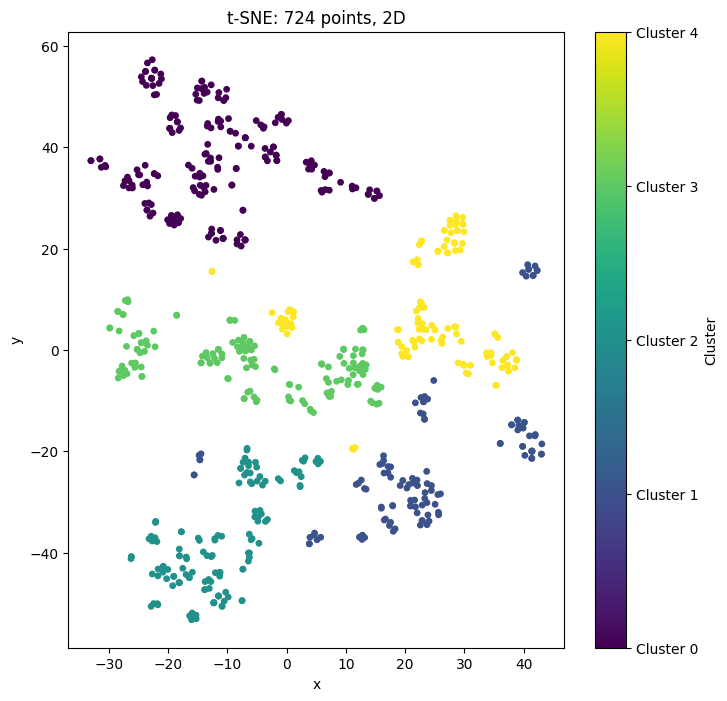

In [ ]:
import matplotlib.pyplot as plt
# Matplotlib를 사용한 시각화

df['Cluster'] = pd.to_numeric(df['Cluster'])

plt.figure(figsize=(8, 8))
scatter = plt.scatter(df['x'], df['y'], c=df['Cluster'], cmap='viridis', s=15)
plt.title('t-SNE: 724 points, 2D')
plt.xlabel('x')
plt.ylabel('y')

cb = plt.colorbar(scatter, label='Cluster')

legend_labels = sorted(df['Cluster'].unique())  # Get unique cluster labels
cb.set_ticks(legend_labels)  # Set ticks to the unique cluster values
cb.set_ticklabels([f'Cluster {label}' for label in legend_labels])  # Set tick labels

plt.show()

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

def plot_distance(idx_pairs, reduced_embeddings_tsne, embedding_matrix, labels, clusters):
    num_pairs = len(idx_pairs)
    num_rows = (num_pairs + 1) // 2  # Calculate number of rows needed based on number of pairs

    # Create the subplot layout
    fig, axs = plt.subplots(num_rows, 2, figsize=(14, 7 * num_rows))

    for i, idx in enumerate(idx_pairs):
        # Calculate cosine similarity and convert to distance
        vec1 = embedding_matrix[idx[0]].reshape(1, -1)
        vec2 = embedding_matrix[idx[1]].reshape(1, -1)
        cos_sim = cosine_similarity(vec1, vec2)[0, 0]
        distance = 1 - cos_sim

        # Determine the subplot position
        row = i // 2
        col = i % 2

        # Plot on the appropriate subplot
        ax = axs[row, col]
        scatter = ax.scatter(reduced_embeddings_tsne[:, 0], reduced_embeddings_tsne[:, 1], c=clusters, cmap='viridis', alpha=0.5)
        ax.scatter(reduced_embeddings_tsne[idx[0], 0], reduced_embeddings_tsne[idx[0], 1], color='red', label=labels[idx[0]])
        ax.scatter(reduced_embeddings_tsne[idx[1], 0], reduced_embeddings_tsne[idx[1], 1], color='blue', label=labels[idx[1]])
        ax.plot([reduced_embeddings_tsne[idx[0], 0], reduced_embeddings_tsne[idx[1], 0]],
                [reduced_embeddings_tsne[idx[0], 1], reduced_embeddings_tsne[idx[1], 1]], 'k--', label=f'Distance: {distance:.2f}')

        ax.legend()

        # Print distance and labels
        print(f"Cosine similarity between index {idx[0]} and index {idx[1]}: {cos_sim:.2f}")
        print(f"Distance between index {idx[0]} and index {idx[1]}: {distance:.2f}")
        print(f"Label for index {idx[0]}: {labels[idx[0]]}")
        print(f"Label for index {idx[1]}: {labels[idx[1]]}")

    # Hide any remaining empty subplots
    if num_pairs < num_rows * 2:
        for j in range(num_pairs, num_rows * 2):
            row = j // 2
            col = j % 2
            axs[row, col].axis('off')

    plt.tight_layout()
    plt.show()

Cosine similarity between index 470 and index 459: 0.87
Distance between index 470 and index 459: 0.13
Label for index 470: ['3_process_tree_case_size_between_7_and_11_noise_92']
Label for index 459: ['3_process_tree_case_size_between_7_and_11_noise_9']
Cosine similarity between index 470 and index 606: 0.86
Distance between index 470 and index 606: 0.14
Label for index 470: ['3_process_tree_case_size_between_7_and_11_noise_92']
Label for index 606: ['4_process_tree_case_size_between_7_and_11_noise_25']
Cosine similarity between index 470 and index 207: 0.83
Distance between index 470 and index 207: 0.17
Label for index 470: ['3_process_tree_case_size_between_7_and_11_noise_92']
Label for index 207: ['1_process_tree_case_size_between_7_and_11_noise_25']
Cosine similarity between index 470 and index 328: 0.79
Distance between index 470 and index 328: 0.21
Label for index 470: ['3_process_tree_case_size_between_7_and_11_noise_92']
Label for index 328: ['2_process_tree_case_size_between_7

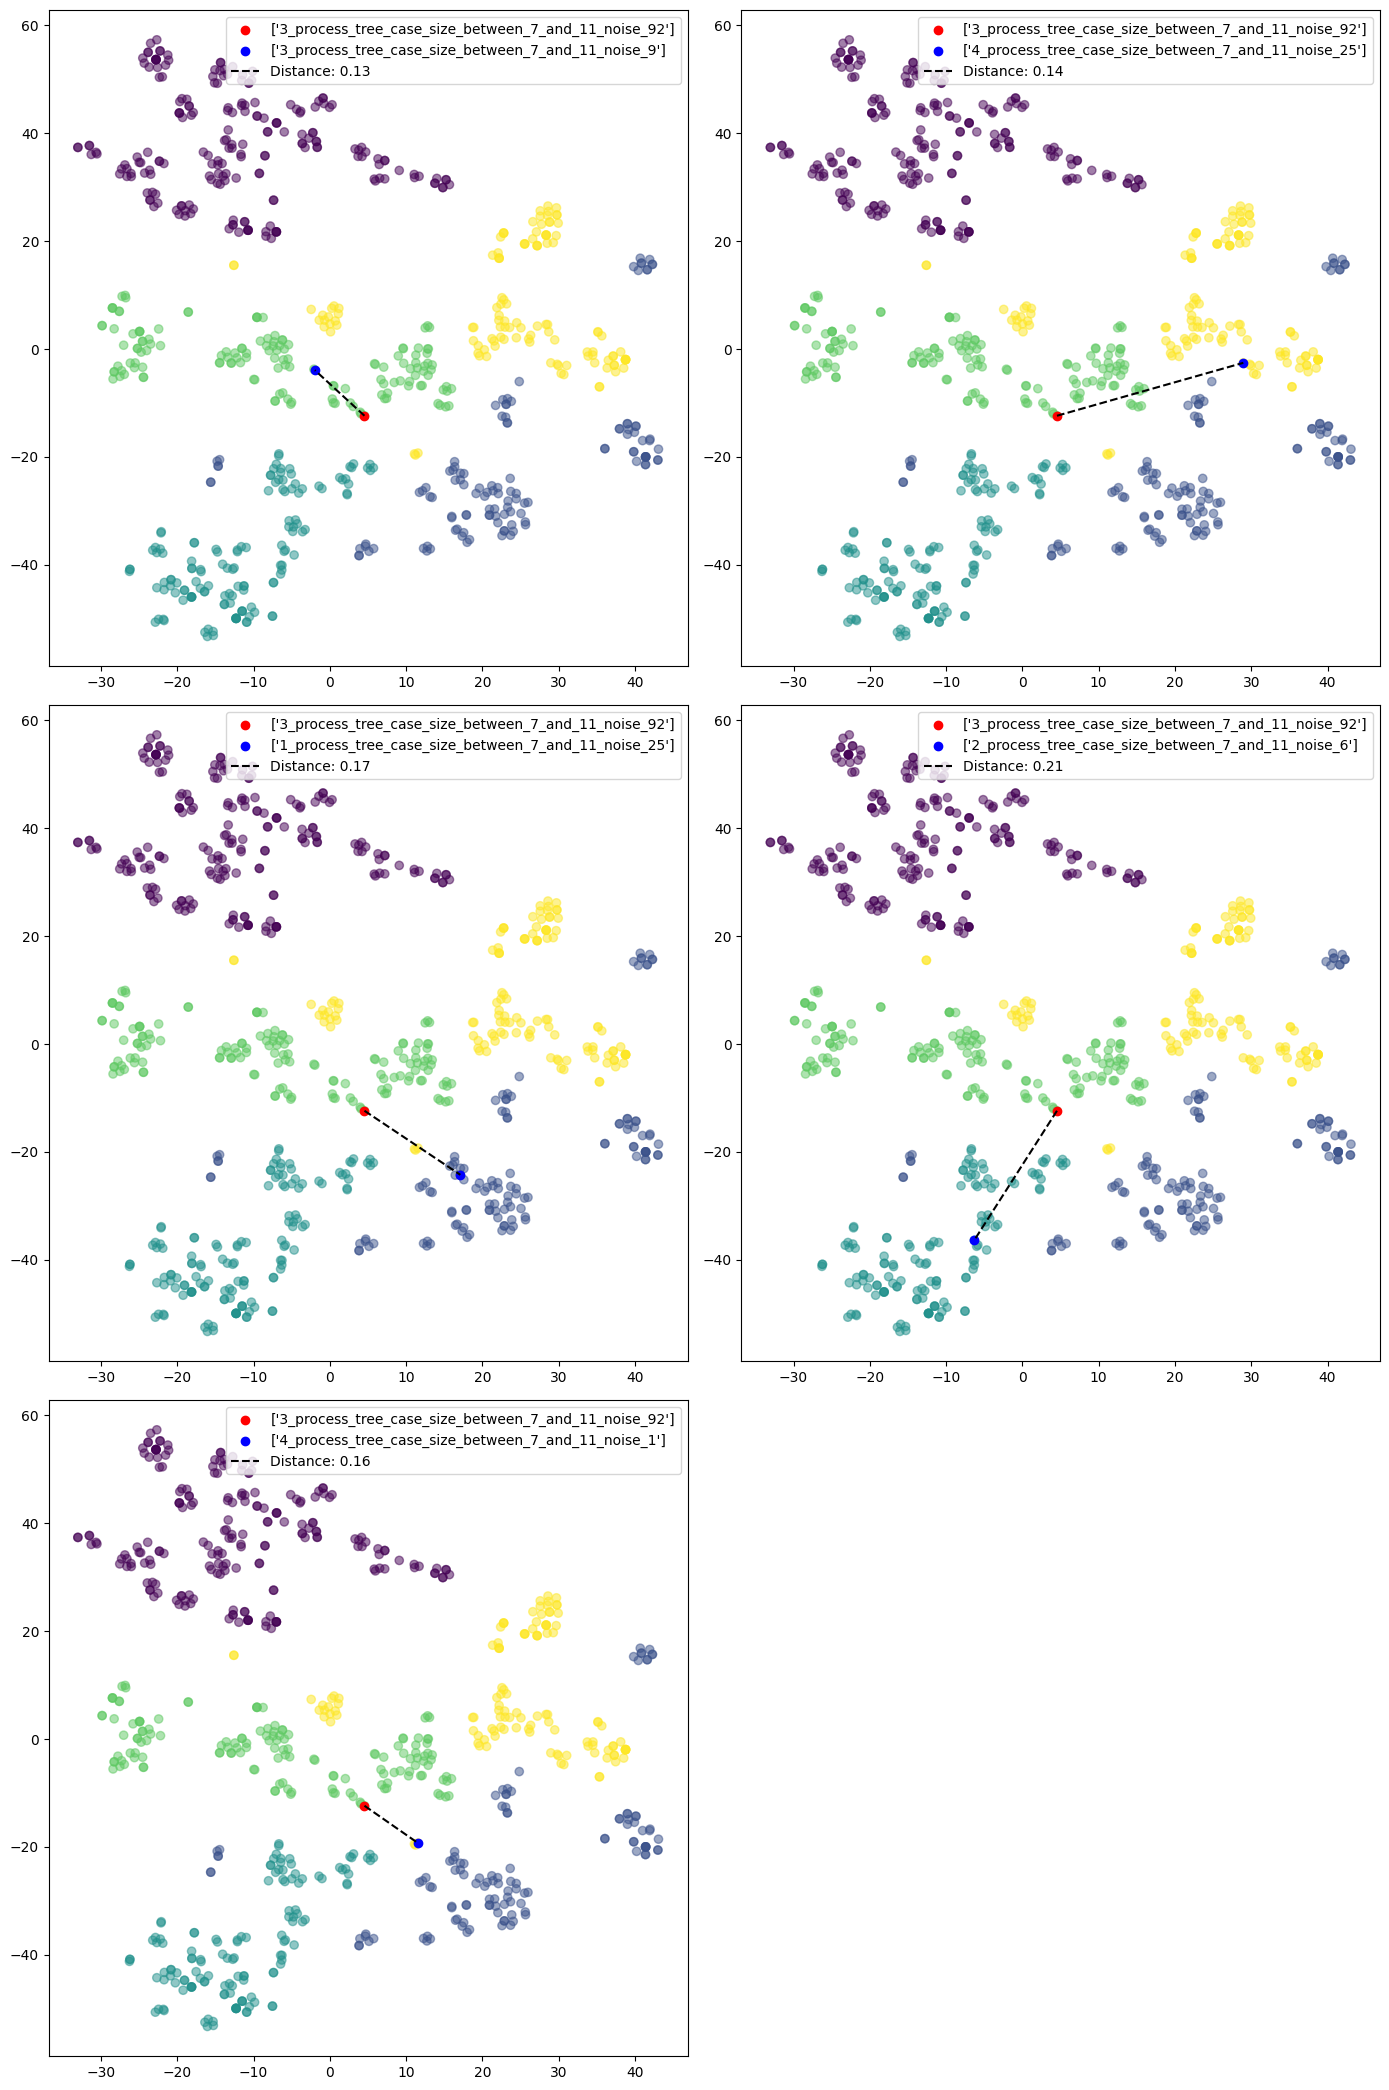

In [ ]:
idx_pairs = [(470, 459), (470, 606), (470, 207), (470, 328), (470, 603)]

plot_distance(idx_pairs, reduced_embeddings_tsne, embedding_matrix, labels, df['Cluster'])

Cosine similarity between index 209 and index 609: 0.82
Distance between index 209 and index 609: 0.18
Label for index 209: ['1_process_tree_case_size_between_7_and_11_noise_50']
Label for index 609: ['4_process_tree_case_size_between_7_and_11_noise_50']
Cosine similarity between index 470 and index 611: 0.92
Distance between index 470 and index 611: 0.08
Label for index 470: ['3_process_tree_case_size_between_7_and_11_noise_92']
Label for index 611: ['4_process_tree_case_size_between_7_and_11_noise_88']
Cosine similarity between index 604 and index 609: 0.83
Distance between index 604 and index 609: 0.17
Label for index 604: ['4_process_tree_case_size_between_7_and_11_noise_12']
Label for index 609: ['4_process_tree_case_size_between_7_and_11_noise_50']
Cosine similarity between index 3 and index 13: 0.93
Distance between index 3 and index 13: 0.07
Label for index 3: ['0_process_tree_case_size_between_7_and_11_noise_8']
Label for index 13: ['0_process_tree_case_size_between_7_and_11_n

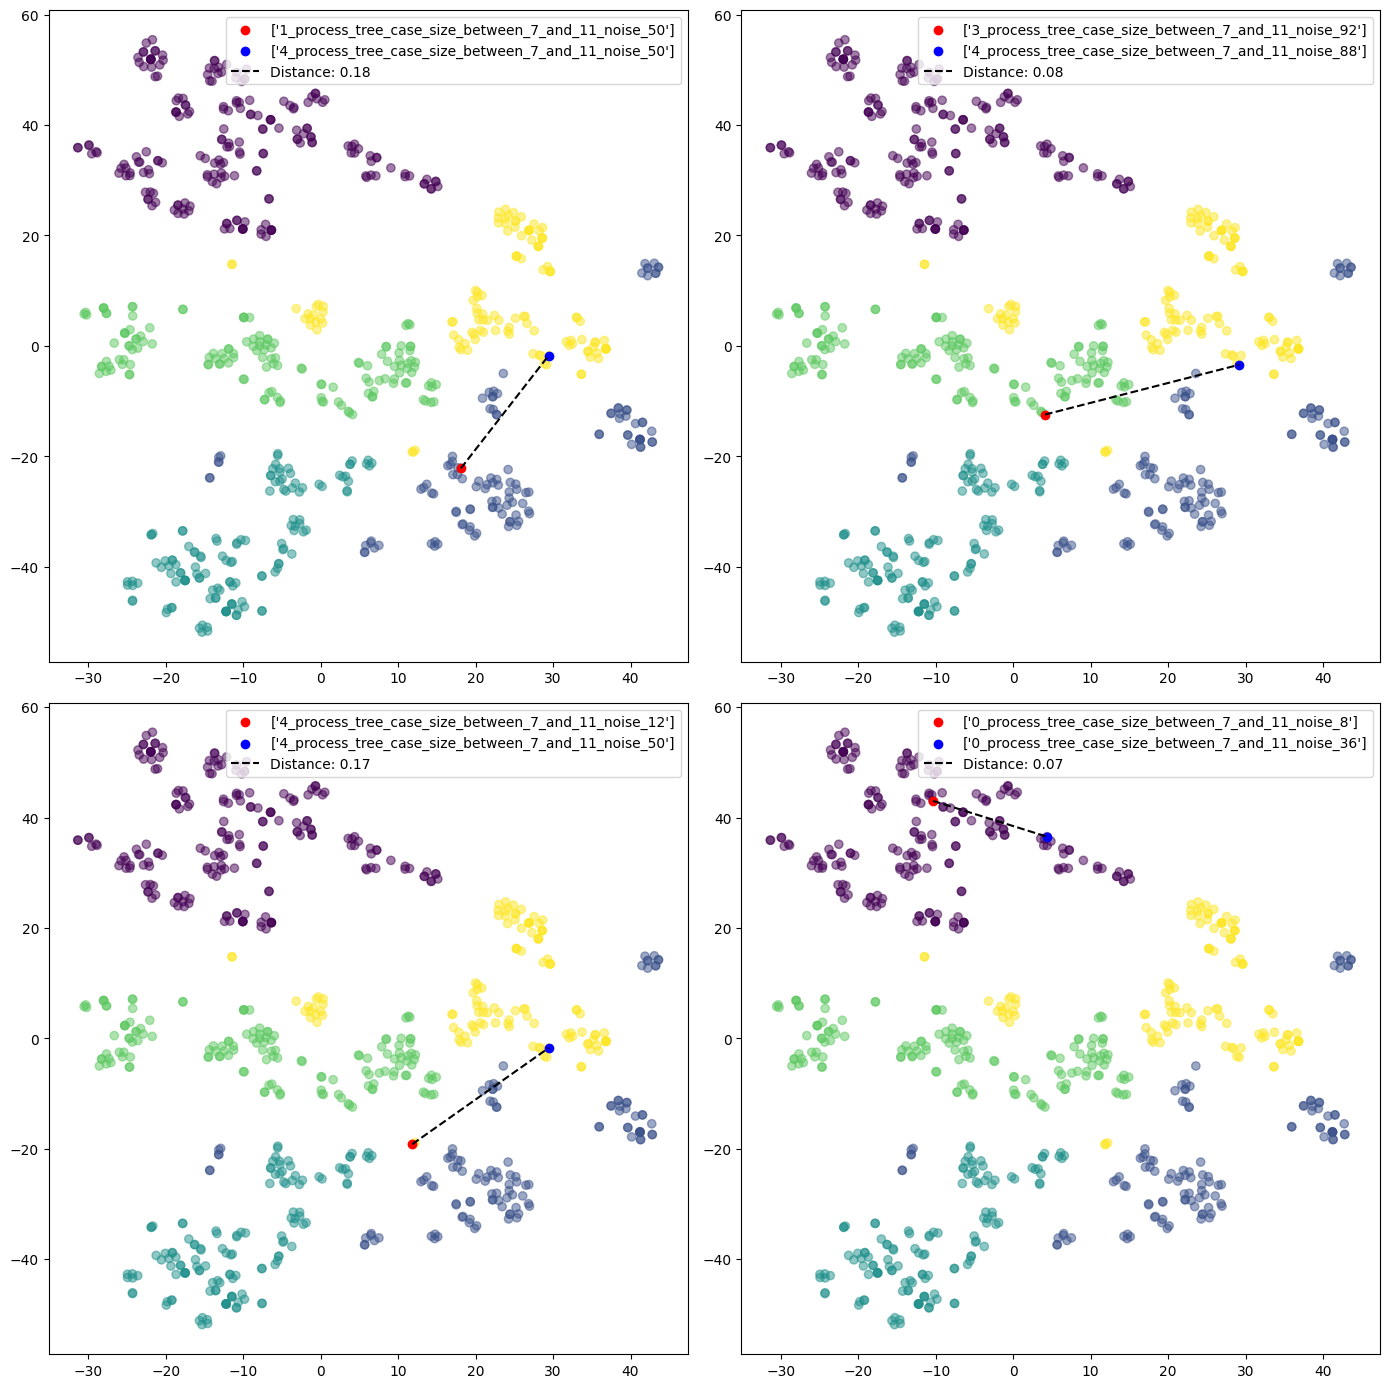

In [ ]:
idx_pairs = [(209, 609), (470, 611), (604, 609), (3, 13)]
# 470, 211, 611, 213, 214, 210, 209, 609, 345
plot_distance(idx_pairs, reduced_embeddings_tsne, embedding_matrix, labels, df['Cluster'])

## Cluerstering_ver2.BPIC rev length 7~8 fixed

In [9]:
import glob
import os
import re

folder_path = "/content/drive/MyDrive/PMLAB/whole_datasets_ver2"

file_path_list = glob.glob(os.path.join(folder_path, "*.txt"))

BPIC = []
labels = []

# 정규식을 사용하여 파일 이름에서 필요한 부분 추출
pattern_filename = r"(\d+_process_tree_case_size_betwee_\d+_and_\d+_noise_\d+)"

for file_path in file_path_list:
    with open(file_path, 'r') as file:
        for line in file:
            matches_label = re.findall(pattern_filename, line)
            labels.append(matches_label)
            pattern = r'"(.*?)"'
            matches = re.findall(pattern, line)
            if matches:  # matches 리스트가 비어 있지 않은 경우에만 처리
                match = matches[0].replace("->", "\u2192")
                BPIC.append(match.replace('"', ""))

In [10]:
tokenized_BPIC = []
tokenized_BPIC.append([tokenize_tree(tree) for tree in BPIC])

In [11]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sbert_model.to(device)

SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

In [12]:
def embed_processes_with_sbert(tokenized_processes):
    # 임베딩을 저장할 리스트 초기화
    sbert_embeddings = []

    # tokenized_processes에 대한 반복문
    for tree_tokens in tokenized_processes:
        # 프로세스 트리를 텍스트로 펼치고 토큰화
        process_tree_text = " ".join(tree_tokens)

        # SBERT 모델을 사용하여 문장 임베딩 얻기 (GPU에서 연산)
        sbert_embedding = sbert_model.encode([process_tree_text], convert_to_tensor=True, device=device)

        # 평균 풀링
        average_pooled_embedding = torch.mean(sbert_embedding, dim=0).cpu().numpy()
        sbert_embeddings.append(average_pooled_embedding)

    # 모든 프로세스 트리에 대한 임베딩이 sbert_embeddings에 저장됨
    return sbert_embeddings

In [13]:
embeddings_groups = []

for group in tokenized_BPIC:
    sbert_embeddings = embed_processes_with_sbert(group)
    embeddings_groups.append(sbert_embeddings)

embedding_matrix = embeddings_groups[0]

### TSNE

In [32]:
import numpy as np
from sklearn.manifold import TSNE

if isinstance(embedding_matrix, list):
    embedding_matrix = np.array(embedding_matrix)

# 데이터 샘플 수 확인
n_samples = embedding_matrix.shape[0]

# perplexity 값을 데이터 샘플 수보다 작게 설정
perplexity = min(30, n_samples - 1)

# t-SNE를 사용하여 2차원으로 축소
tsne = TSNE(n_components=2, perplexity=perplexity, random_state=12)
reduced_embeddings_tsne = tsne.fit_transform(embedding_matrix)

In [33]:
import pandas as pd
import plotly.express as px
import re

# DataFrame으로 변환
df = pd.DataFrame(reduced_embeddings_tsne, columns=['x', 'y'])
df['Label'] = labels
df['idx'] = df.index

# 기관 Lable 추가
def extract_first_digit(label):
    match = re.match(r'(\d+)_', label)
    return str(match.group(1)) if match else None

df['Cluster'] = df['Label'].apply(lambda x: extract_first_digit(x[0]))

# Plotly를 사용한 시각화
fig = px.scatter(df, x='x', y='y', color='Cluster', hover_name='Label', hover_data=['idx'],
                 title='t-SNE: 2D')
fig.update_layout(
    width=800,
    height=800
)
fig.show()


In [31]:
from sklearn.metrics.pairwise import euclidean_distances

distances = euclidean_distances(reduced_embeddings_tsne)

# 가장 먼 쌍과 가장 가까운 쌍 찾기
np.fill_diagonal(distances, np.inf)  # 자기 자신과의 거리는 무시
max_dist_idx = np.unravel_index(np.argmax(distances), distances.shape)
min_dist_idx = np.unravel_index(np.argmin(distances), distances.shape)

# 자기 자신과의 거리 (대각선) 무한대로 설정
np.fill_diagonal(distances, np.inf)

# 무한대를 제외한 최대 거리 계산
finite_distances = distances[distances != np.inf]
true_max_distance = np.max(finite_distances)
true_max_dist_idx = np.unravel_index(np.argmax(distances == true_max_distance), distances.shape)

# 최소 거리 계산
min_dist_idx = np.unravel_index(np.argmin(distances), distances.shape)
min_distance = distances[min_dist_idx]

# 결과 출력
print(f"최대 거리: {true_max_distance}, 인덱스 쌍: {true_max_dist_idx}")
print(f"최소 거리: {min_distance}, 인덱스 쌍: {min_dist_idx}")

최대 거리: 319.46142578125, 인덱스 쌍: (12, 26)
최소 거리: 47.31086349487305, 인덱스 쌍: (2, 14)


### Clustering by Label

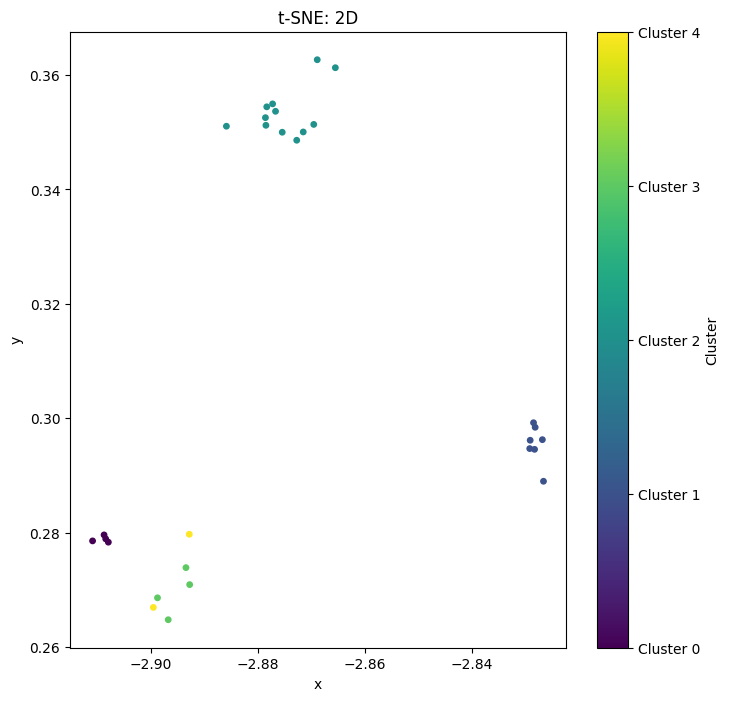

In [34]:
import matplotlib.pyplot as plt
# Matplotlib를 사용한 시각화

df['Cluster'] = pd.to_numeric(df['Cluster'])

plt.figure(figsize=(8, 8))
scatter = plt.scatter(df['x'], df['y'], c=df['Cluster'], cmap='viridis', s=15)
plt.title('t-SNE: 2D')
plt.xlabel('x')
plt.ylabel('y')

cb = plt.colorbar(scatter, label='Cluster')

legend_labels = sorted(df['Cluster'].unique())  # Get unique cluster labels
cb.set_ticks(legend_labels)  # Set ticks to the unique cluster values
cb.set_ticklabels([f'Cluster {label}' for label in legend_labels])  # Set tick labels

plt.show()

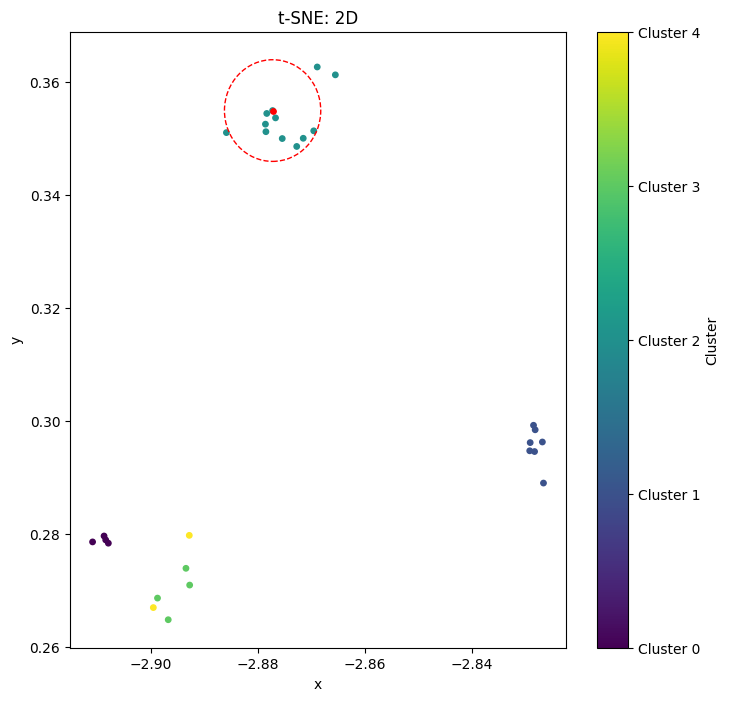

In [54]:
import matplotlib.pyplot as plt
import pandas as pd

df['Cluster'] = pd.to_numeric(df['Cluster'])

plt.figure(figsize=(8, 8))
scatter = plt.scatter(df['x'], df['y'], c=df['Cluster'], cmap='viridis', s=15)
plt.title('t-SNE: 2D')
plt.xlabel('x')
plt.ylabel('y')

cb = plt.colorbar(scatter, label='Cluster')

legend_labels = sorted(df['Cluster'].unique())  # Get unique cluster labels
cb.set_ticks(legend_labels)  # Set ticks to the unique cluster values
cb.set_ticklabels([f'Cluster {label}' for label in legend_labels])  # Set tick labels

# index가 10인 점을 중심으로 원을 그리기
index = 19
center_x, center_y = df.loc[index, 'x'], df.loc[index, 'y']
radius = 0.009

circle = plt.Circle((center_x, center_y), radius, color='r', fill=False, linestyle='--')
plt.gca().add_patch(circle)
plt.scatter(center_x, center_y, color='red', s=15, label='Center Point')

plt.show()


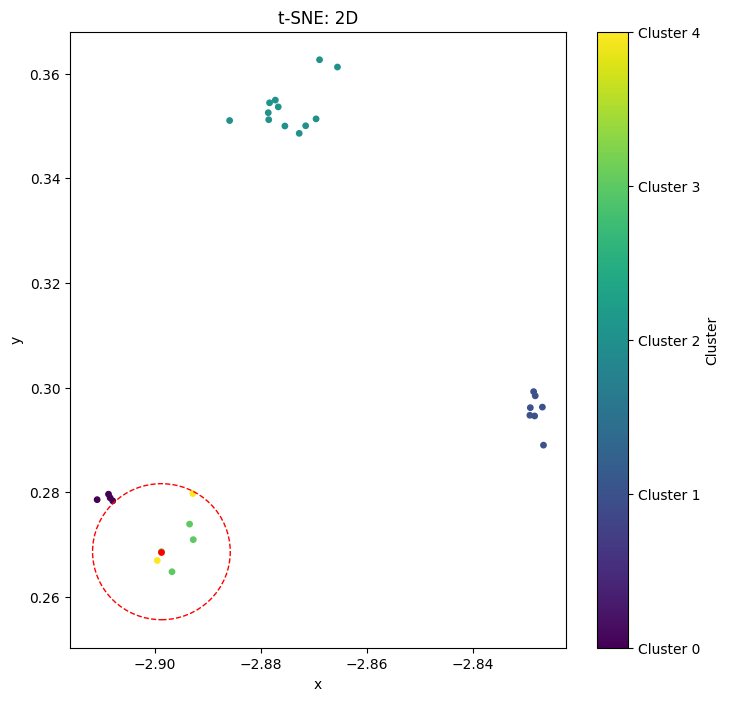

In [58]:
import matplotlib.pyplot as plt
import pandas as pd

df['Cluster'] = pd.to_numeric(df['Cluster'])

plt.figure(figsize=(8, 8))
scatter = plt.scatter(df['x'], df['y'], c=df['Cluster'], cmap='viridis', s=15)
plt.title('t-SNE: 2D')
plt.xlabel('x')
plt.ylabel('y')

cb = plt.colorbar(scatter, label='Cluster')

legend_labels = sorted(df['Cluster'].unique())  # Get unique cluster labels
cb.set_ticks(legend_labels)  # Set ticks to the unique cluster values
cb.set_ticklabels([f'Cluster {label}' for label in legend_labels])  # Set tick labels

# index가 10인 점을 중심으로 원을 그리기
index = 25
center_x, center_y = df.loc[index, 'x'], df.loc[index, 'y']
radius = 0.013

circle = plt.Circle((center_x, center_y), radius, color='r', fill=False, linestyle='--')
plt.gca().add_patch(circle)
plt.scatter(center_x, center_y, color='red', s=15, label='Center Point')

plt.show()


In [78]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

def plot_distance(idx_pairs, reduced_embeddings_tsne, embedding_matrix, labels, clusters):
    num_pairs = len(idx_pairs)
    num_rows = (num_pairs + 1) // 2  # Calculate number of rows needed based on number of pairs

    # Create the subplot layout, handle case with only one pair differently
    if num_pairs == 1:
        fig, axs = plt.subplots(1, 1, figsize=(14, 7))
        axs = np.array([axs])  # Ensure axs is an array for consistent indexing
    else:
        fig, axs = plt.subplots(num_rows, 2, figsize=(14, 7 * num_rows))

    for i, idx in enumerate(idx_pairs):
        # Calculate cosine similarity and convert to distance
        vec1 = embedding_matrix[idx[0]].reshape(1, -1)
        vec2 = embedding_matrix[idx[1]].reshape(1, -1)
        cos_sim = cosine_similarity(vec1, vec2)[0, 0]
        distance = 1 - cos_sim

        # Determine the subplot position
        row = i // 2
        col = i % 2

        # Plot on the appropriate subplot
        if num_pairs == 1:
            ax = axs[0]
        elif num_rows == 1:
            ax = axs[col]
        else:
            ax = axs[row, col]

        scatter = ax.scatter(reduced_embeddings_tsne[:, 0], reduced_embeddings_tsne[:, 1], c=clusters, cmap='viridis', alpha=0.5)
        ax.scatter(reduced_embeddings_tsne[idx[0], 0], reduced_embeddings_tsne[idx[0], 1], color='red', label=labels[idx[0]])
        ax.scatter(reduced_embeddings_tsne[idx[1], 0], reduced_embeddings_tsne[idx[1], 1], color='blue', label=labels[idx[1]])
        ax.plot([reduced_embeddings_tsne[idx[0], 0], reduced_embeddings_tsne[idx[1], 0]],
                [reduced_embeddings_tsne[idx[0], 1], reduced_embeddings_tsne[idx[1], 1]], 'k--', label=f'Distance: {distance:.2f}')

        ax.legend()

        # Print distance and labels
        print(f"Cosine similarity between index {idx[0]} and index {idx[1]}: {cos_sim:.2f}")
        print(f"Distance between index {idx[0]} and index {idx[1]}: {distance:.2f}")
        print(f"Label for index {idx[0]}: {labels[idx[0]]}")
        print(f"Label for index {idx[1]}: {labels[idx[1]]}")

    # Hide any remaining empty subplots if num_pairs is not even
    if num_pairs < num_rows * 2 and num_pairs > 1:
        for j in range(num_pairs, num_rows * 2):
            row = j // 2
            col = j % 2
            axs[row, col].axis('off')

    plt.tight_layout()
    plt.show()

Cosine similarity between index 27 and index 28: 0.90
Distance between index 27 and index 28: 0.10
Label for index 27: ['4_process_tree_case_size_betwee_7_and_8_noise_1']
Label for index 28: ['4_process_tree_case_size_betwee_7_and_8_noise_50']
Cosine similarity between index 25 and index 28: 0.83
Distance between index 25 and index 28: 0.17
Label for index 25: ['3_process_tree_case_size_betwee_7_and_8_noise_50']
Label for index 28: ['4_process_tree_case_size_betwee_7_and_8_noise_50']
Cosine similarity between index 0 and index 2: 0.97
Distance between index 0 and index 2: 0.03
Label for index 0: ['0_process_tree_case_size_betwee_7_and_8_noise_1']
Label for index 2: ['0_process_tree_case_size_betwee_7_and_8_noise_43']
Cosine similarity between index 15 and index 26: 0.59
Distance between index 15 and index 26: 0.41
Label for index 15: ['2_process_tree_case_size_betwee_7_and_8_noise_20']
Label for index 26: ['3_process_tree_case_size_betwee_7_and_8_noise_67']


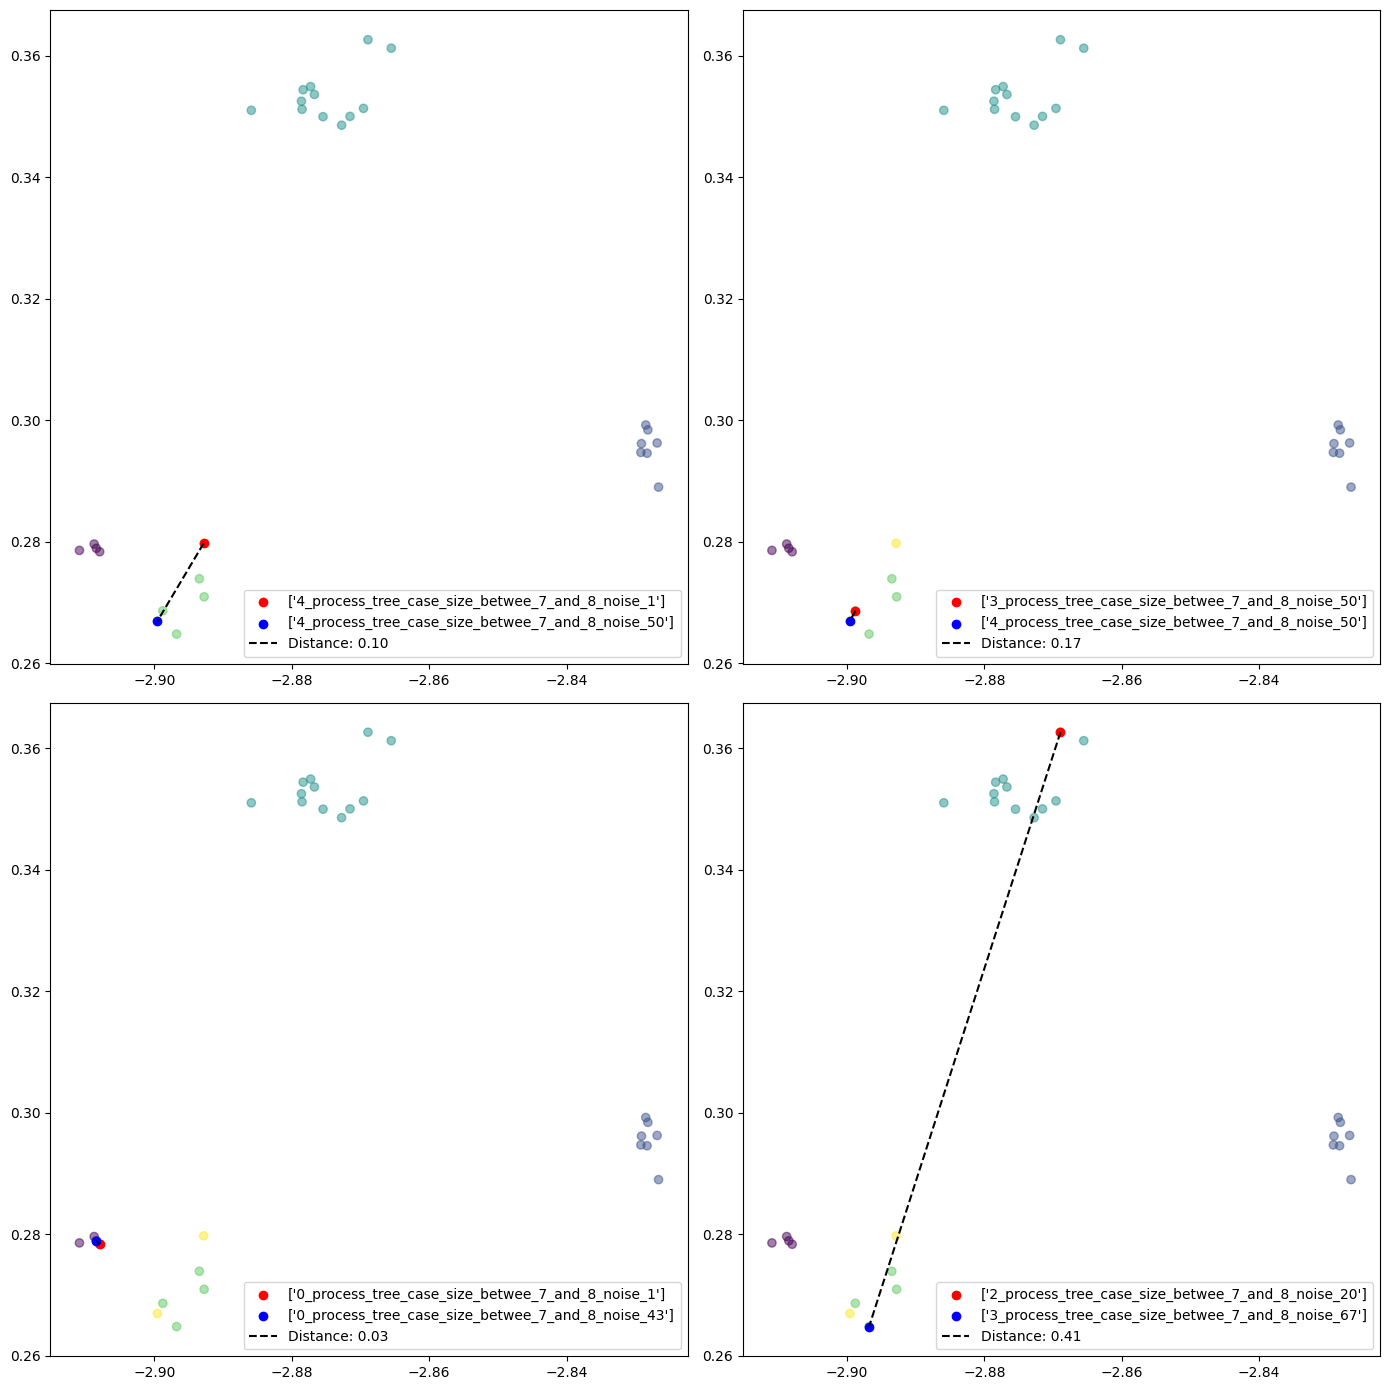

In [36]:
idx_pairs = [(27, 28), (25, 28), (0,2), (15, 26)]

plot_distance(idx_pairs, reduced_embeddings_tsne, embedding_matrix, labels, df['Cluster'])

Cosine similarity between index 19 and index 13: 0.95
Distance between index 19 and index 13: 0.05
Label for index 19: ['2_process_tree_case_size_betwee_7_and_8_noise_36']
Label for index 13: ['2_process_tree_case_size_betwee_7_and_8_noise_14']
Cosine similarity between index 19 and index 11: 0.96
Distance between index 19 and index 11: 0.04
Label for index 19: ['2_process_tree_case_size_betwee_7_and_8_noise_36']
Label for index 11: ['2_process_tree_case_size_betwee_7_and_8_noise_1']
Cosine similarity between index 19 and index 15: 0.93
Distance between index 19 and index 15: 0.07
Label for index 19: ['2_process_tree_case_size_betwee_7_and_8_noise_36']
Label for index 15: ['2_process_tree_case_size_betwee_7_and_8_noise_20']
Cosine similarity between index 25 and index 0: 0.81
Distance between index 25 and index 0: 0.19
Label for index 25: ['3_process_tree_case_size_betwee_7_and_8_noise_50']
Label for index 0: ['0_process_tree_case_size_betwee_7_and_8_noise_1']
Cosine similarity between

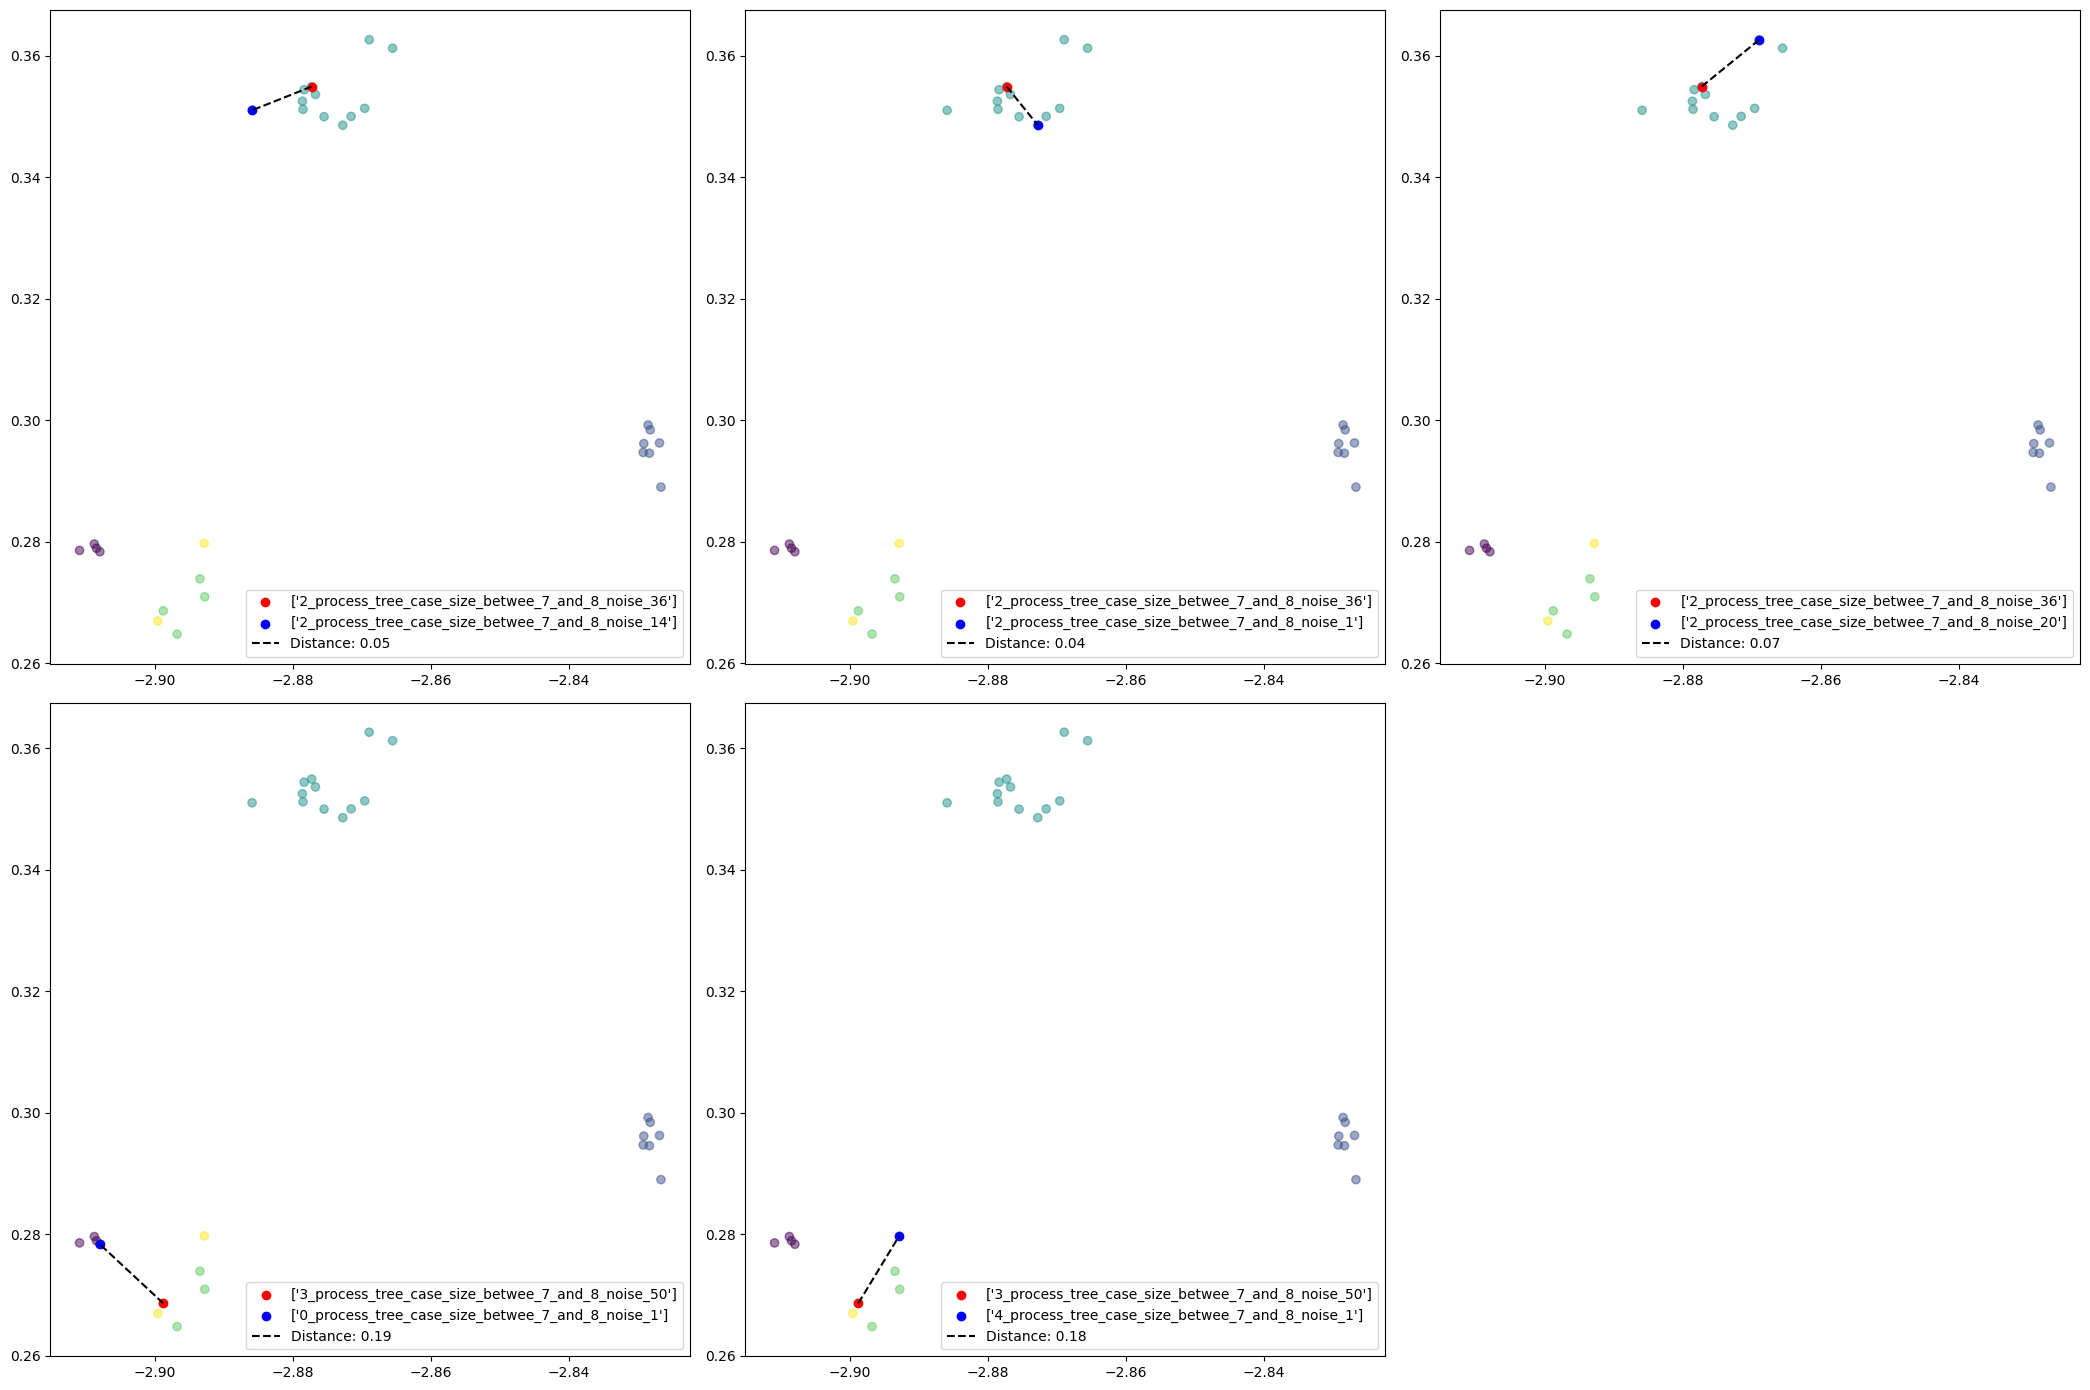

In [60]:
idx_pairs = [(19, 13), (19,11),(19, 15), (25,0), (25,27)]

plot_distance(idx_pairs, reduced_embeddings_tsne, embedding_matrix, labels, df['Cluster'])

## Cluerstering_ver3.BPIC rev length 7 ~ 8 fixed + 8 ~ 9 추가 진행 예정

In [61]:
import glob
import os
import re

folder_path = "/content/drive/MyDrive/PMLAB/whole_datasets_ver3"

file_path_list = glob.glob(os.path.join(folder_path, "*.txt"))

BPIC = []
labels = []

# 정규식을 사용하여 파일 이름에서 필요한 부분 추출
pattern_filename = r"(\d+_process_tree_case_size_betwee_\d+_and_\d+_noise_\d+)"

for file_path in file_path_list:
    with open(file_path, 'r') as file:
        for line in file:
            matches_label = re.findall(pattern_filename, line)
            labels.append(matches_label)
            pattern = r'"(.*?)"'
            matches = re.findall(pattern, line)
            if matches:  # matches 리스트가 비어 있지 않은 경우에만 처리
                match = matches[0].replace("->", "\u2192")
                BPIC.append(match.replace('"', ""))

In [62]:
tokenized_BPIC = []
tokenized_BPIC.append([tokenize_tree(tree) for tree in BPIC])

In [63]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sbert_model.to(device)

SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

In [64]:
def embed_processes_with_sbert(tokenized_processes):
    # 임베딩을 저장할 리스트 초기화
    sbert_embeddings = []

    # tokenized_processes에 대한 반복문
    for tree_tokens in tokenized_processes:
        # 프로세스 트리를 텍스트로 펼치고 토큰화
        process_tree_text = " ".join(tree_tokens)

        # SBERT 모델을 사용하여 문장 임베딩 얻기 (GPU에서 연산)
        sbert_embedding = sbert_model.encode([process_tree_text], convert_to_tensor=True, device=device)

        # 평균 풀링
        average_pooled_embedding = torch.mean(sbert_embedding, dim=0).cpu().numpy()
        sbert_embeddings.append(average_pooled_embedding)

    # 모든 프로세스 트리에 대한 임베딩이 sbert_embeddings에 저장됨
    return sbert_embeddings

In [65]:
embeddings_groups = []

for group in tokenized_BPIC:
    sbert_embeddings = embed_processes_with_sbert(group)
    embeddings_groups.append(sbert_embeddings)

embedding_matrix = embeddings_groups[0]

### TSNE

In [66]:
import numpy as np
from sklearn.manifold import TSNE

if isinstance(embedding_matrix, list):
    embedding_matrix = np.array(embedding_matrix)

# 데이터 샘플 수 확인
n_samples = embedding_matrix.shape[0]

# perplexity 값을 데이터 샘플 수보다 작게 설정
perplexity = min(30, n_samples - 1)

# t-SNE를 사용하여 2차원으로 축소
tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
reduced_embeddings_tsne = tsne.fit_transform(embedding_matrix)

In [67]:
import pandas as pd
import plotly.express as px
import re

# DataFrame으로 변환
df = pd.DataFrame(reduced_embeddings_tsne, columns=['x', 'y'])
df['Label'] = labels
df['idx'] = df.index

# 기관 Lable 추가
def extract_first_digit(label):
    match = re.match(r'(\d+)_', label)
    return str(match.group(1)) if match else None

df['Cluster'] = df['Label'].apply(lambda x: extract_first_digit(x[0]))

# Plotly를 사용한 시각화
fig = px.scatter(df, x='x', y='y', color='Cluster', hover_name='Label', hover_data=['idx'],
                 title='t-SNE: 2D')
fig.update_layout(
    width=800,
    height=800
)
fig.show()


In [68]:
from sklearn.metrics.pairwise import euclidean_distances

distances = euclidean_distances(reduced_embeddings_tsne)

# 가장 먼 쌍과 가장 가까운 쌍 찾기
np.fill_diagonal(distances, np.inf)  # 자기 자신과의 거리는 무시
max_dist_idx = np.unravel_index(np.argmax(distances), distances.shape)
min_dist_idx = np.unravel_index(np.argmin(distances), distances.shape)

# 자기 자신과의 거리 (대각선) 무한대로 설정
np.fill_diagonal(distances, np.inf)

# 무한대를 제외한 최대 거리 계산
finite_distances = distances[distances != np.inf]
true_max_distance = np.max(finite_distances)
true_max_dist_idx = np.unravel_index(np.argmax(distances == true_max_distance), distances.shape)

# 최소 거리 계산
min_dist_idx = np.unravel_index(np.argmin(distances), distances.shape)
min_distance = distances[min_dist_idx]

# 결과 출력
print(f"최대 거리: {true_max_distance}, 인덱스 쌍: {true_max_dist_idx}")
print(f"최소 거리: {min_distance}, 인덱스 쌍: {min_dist_idx}")

최대 거리: 9.19517993927002, 인덱스 쌍: (0, 24)
최소 거리: 0.028787460178136826, 인덱스 쌍: (1, 2)


### Clustering by Label

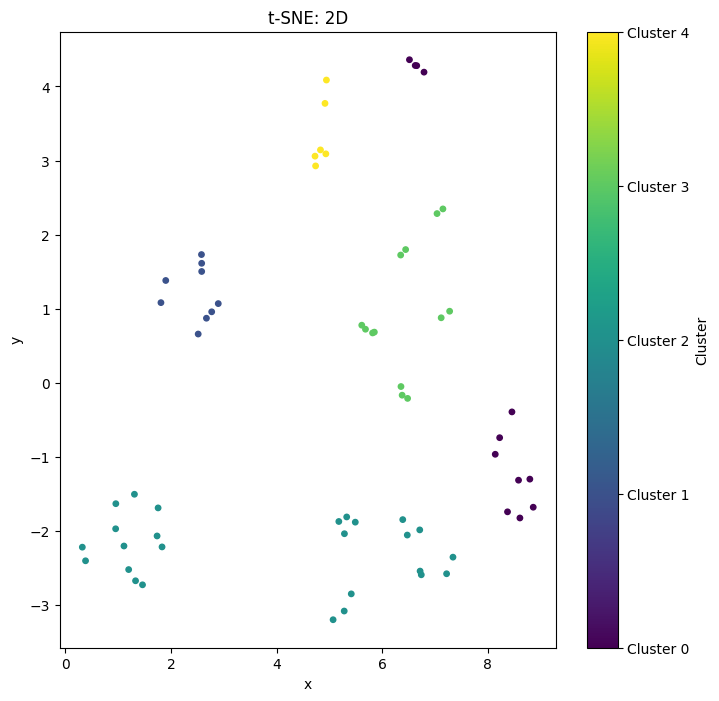

In [69]:
import matplotlib.pyplot as plt
# Matplotlib를 사용한 시각화

df['Cluster'] = pd.to_numeric(df['Cluster'])

plt.figure(figsize=(8, 8))
scatter = plt.scatter(df['x'], df['y'], c=df['Cluster'], cmap='viridis', s=15)
plt.title('t-SNE: 2D')
plt.xlabel('x')
plt.ylabel('y')

cb = plt.colorbar(scatter, label='Cluster')

legend_labels = sorted(df['Cluster'].unique())  # Get unique cluster labels
cb.set_ticks(legend_labels)  # Set ticks to the unique cluster values
cb.set_ticklabels([f'Cluster {label}' for label in legend_labels])  # Set tick labels

plt.show()

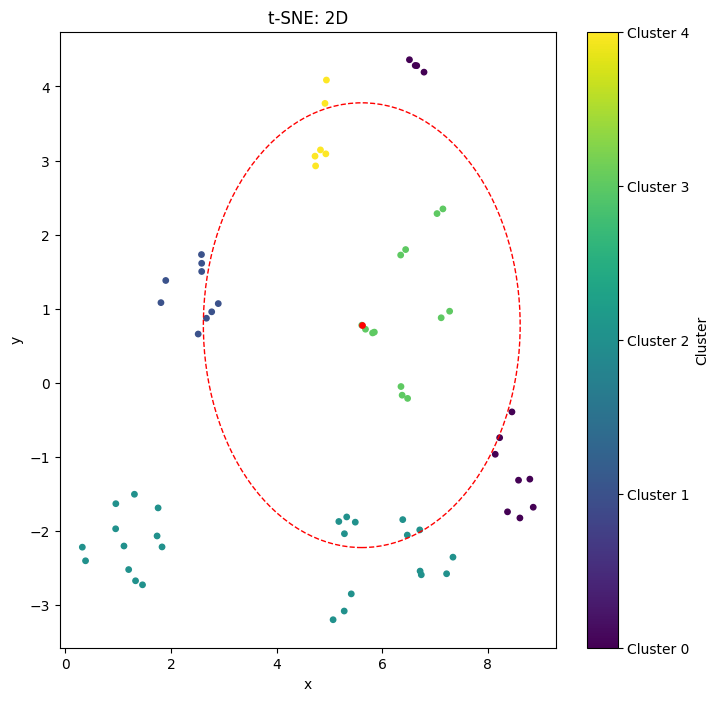

In [76]:
import matplotlib.pyplot as plt
import pandas as pd

df['Cluster'] = pd.to_numeric(df['Cluster'])

plt.figure(figsize=(8, 8))
scatter = plt.scatter(df['x'], df['y'], c=df['Cluster'], cmap='viridis', s=15)
plt.title('t-SNE: 2D')
plt.xlabel('x')
plt.ylabel('y')

cb = plt.colorbar(scatter, label='Cluster')

legend_labels = sorted(df['Cluster'].unique())  # Get unique cluster labels
cb.set_ticks(legend_labels)  # Set ticks to the unique cluster values
cb.set_ticklabels([f'Cluster {label}' for label in legend_labels])  # Set tick labels

# index가 10인 점을 중심으로 원을 그리기
index = 55
center_x, center_y = df.loc[index, 'x'], df.loc[index, 'y']
radius = 3

circle = plt.Circle((center_x, center_y), radius, color='r', fill=False, linestyle='--')
plt.gca().add_patch(circle)
plt.scatter(center_x, center_y, color='red', s=15, label='Center Point')

plt.show()


Cosine similarity between index 1 and index 2: 0.99
Distance between index 1 and index 2: 0.01
Label for index 1: ['0_process_tree_case_size_betwee_7_and_8_noise_10']
Label for index 2: ['0_process_tree_case_size_betwee_7_and_8_noise_43']
Cosine similarity between index 0 and index 24: 0.63
Distance between index 0 and index 24: 0.37
Label for index 0: ['0_process_tree_case_size_betwee_7_and_8_noise_1']
Label for index 24: ['2_process_tree_case_size_betwee_7_and_8_noise_15']


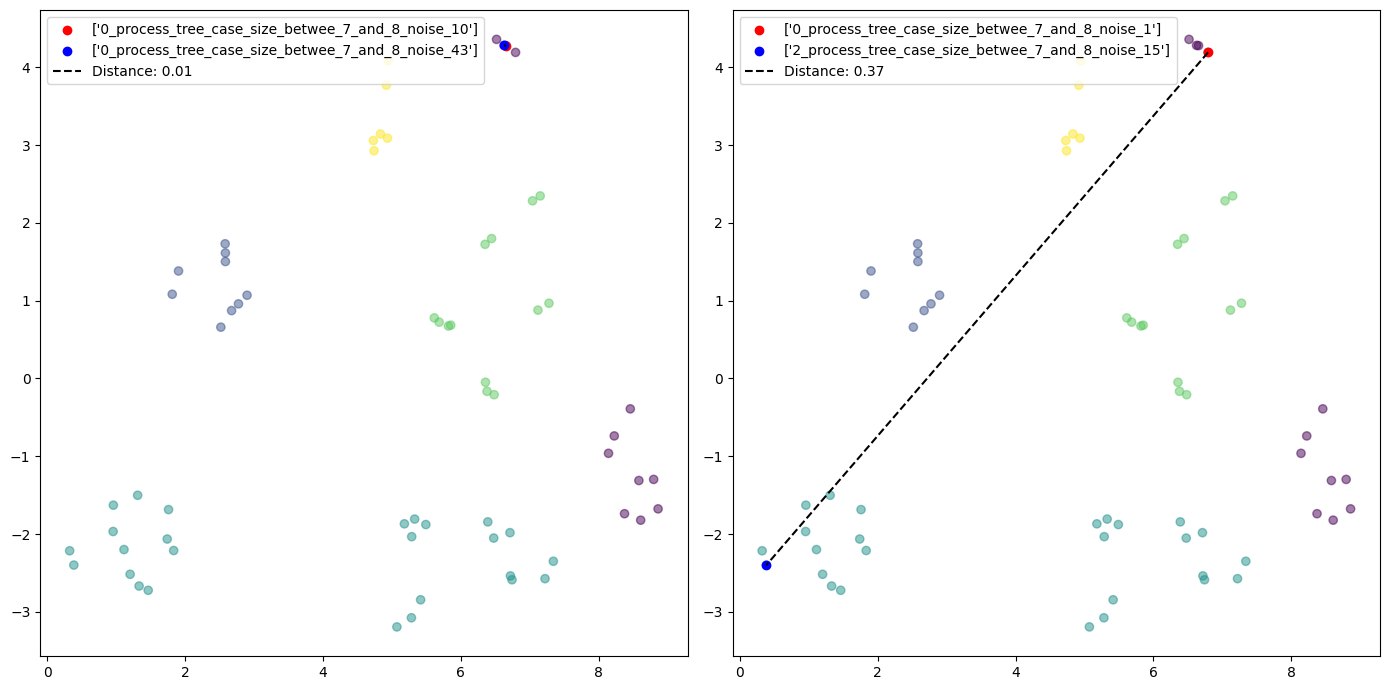

In [ ]:
idx_pairs = [(1,2), (0,24)]

plot_distance(idx_pairs, reduced_embeddings_tsne, embedding_matrix, labels, df['Cluster'])

Cosine similarity between index 55 and index 10: 0.85
Distance between index 55 and index 10: 0.15
Label for index 55: ['3_process_tree_case_size_betwee_8_and_9_noise_40']
Label for index 10: ['0_process_tree_case_size_betwee_8_and_9_noise_67']
Cosine similarity between index 55 and index 17: 0.85
Distance between index 55 and index 17: 0.15
Label for index 55: ['3_process_tree_case_size_betwee_8_and_9_noise_40']
Label for index 17: ['1_process_tree_case_size_betwee_7_and_8_noise_67']
Cosine similarity between index 55 and index 37: 0.84
Distance between index 55 and index 37: 0.16
Label for index 55: ['3_process_tree_case_size_betwee_8_and_9_noise_40']
Label for index 37: ['2_process_tree_case_size_betwee_8_and_9_noise_20']
Cosine similarity between index 55 and index 65: 0.80
Distance between index 55 and index 65: 0.20
Label for index 55: ['3_process_tree_case_size_betwee_8_and_9_noise_40']
Label for index 65: ['4_process_tree_case_size_betwee_8_and_9_noise_67']


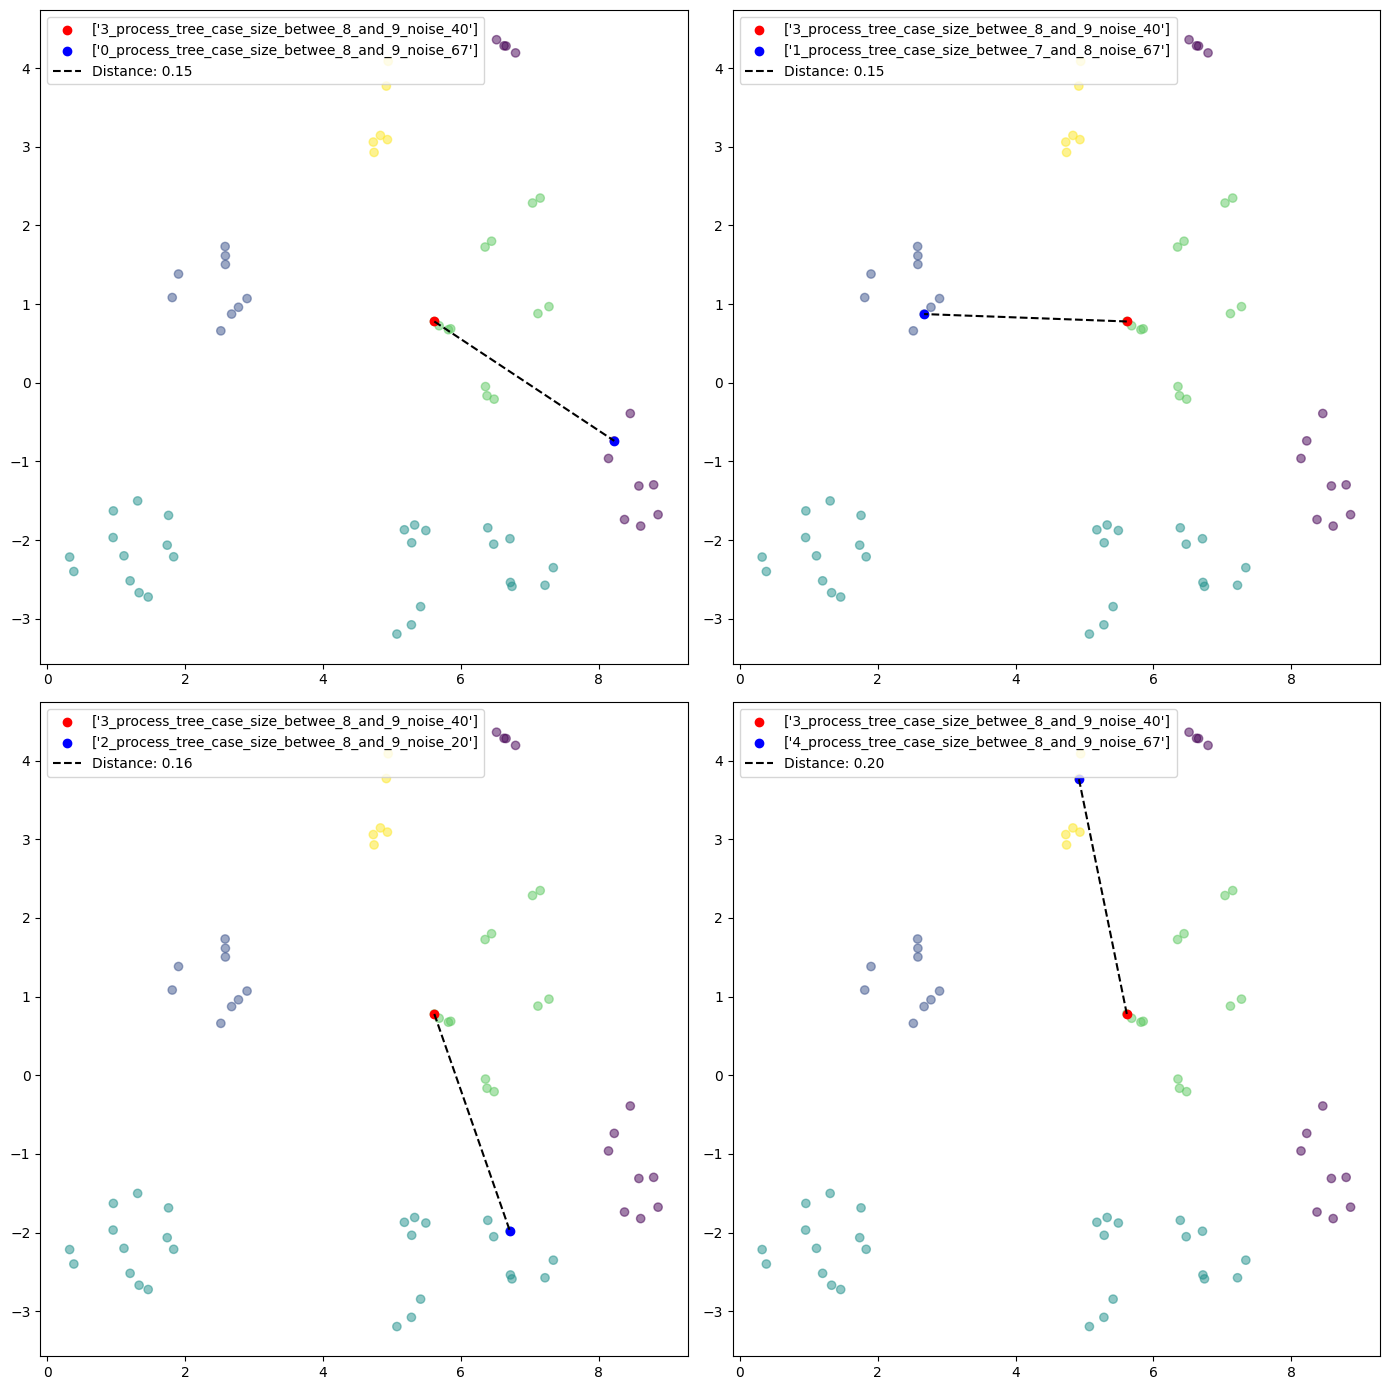

In [79]:
idx_pairs = [(55,10), (55,17), (55,37), (55,65)]

plot_distance(idx_pairs, reduced_embeddings_tsne, embedding_matrix, labels, df['Cluster'])